# Dependency Imports and Environment Setup

In this opening section, the notebook pulls in all the Python packages and modules needed downstream—everything from file I/O '(os, csv, pickle)' and date handling (datetime) to scientific computing and ML tools (numpy, scikit-learn, torch). By centralizing imports here, the code ensures that the environment is reproducible and that any missing dependencies are caught immediately, which is essential for both collaboration and rerunning the analysis on new machines.

In [187]:
import csv
import linecache
import os
import pickle
import random
import shutil
import warnings
from datetime import datetime
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (auc,confusion_matrix,f1_score,precision_score,recall_score,roc_curve,)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import (EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau,TensorBoard,)
from tensorflow.keras.layers import (Activation,BatchNormalization,Conv2D,Dense,Dropout,Embedding,GRU,Input,LSTM,MaxPooling2D,RepeatVector,Reshape,TimeDistributed,)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler       # changed
from sklearn.metrics import (
        confusion_matrix, precision_score,
        recall_score, f1_score, roc_curve, auc
    )
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
        Input, Dense, BatchNormalization, Dropout
    )
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
        ReduceLROnPlateau, EarlyStopping
    )

# Utility Function Definitions

Here, we defines a suite of reusable routines—e.g. functions to count lines in a file, parse timestamps, normalize data, and wrap common training or evaluation steps. Abstracting these operations into “helper” functions keeps the main workflow clean, avoids duplication, and makes it far easier to debug or extend individual pieces (for example, swapping out one preprocessing step without rewriting every cell where it’s used).

In [297]:

def path_check(path):
    folders=os.path.exists(path)
    if not folders:
        print("Create new folders: ' %s ' successfully!"%(path))
        os.makedirs(path)
    else:
        print("The folder  ' %s ' exits, Some data will be rewrited !"%(path))
        pass

def count_line(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for _ in f)
    

def detect_anomaly_start(loss_values, threshold, consecutive_days):
    anomaly_start = None
    consecutive_count = 0
    for day, loss in enumerate(loss_values):
        if loss > threshold:
            consecutive_count += 1
            if consecutive_count >= consecutive_days:
                anomaly_start = day - consecutive_days + 1
                break
        else:
            consecutive_count = 0
    return anomaly_start


def calculate_threshold(loss_values, multiplier):

    median_loss = np.median(loss_values)
    mad         = np.median(np.abs(loss_values - median_loss))
    return median_loss + multiplier * mad


# Load The Data

This section reads in the raw datasets—user activity logs, label files, and any metadata—into memory (often as pandas DataFrames or serialized Python objects). It also performs sanity checks (missing values, basic statistics) to confirm that the files are correctly formatted and that the dataset’s shape matches expectations. Early validation here prevents “silent” errors later in modeling and makes sure that downstream feature extraction is built on reliable inputs.

In [3]:
device_file_path = '/Users/macos/Desktop/memoire/r4.2/device.csv'
email_file_path = '/Users/macos/Desktop/memoire/r4.2/email.csv'
http_file_path = '/Users/macos/Desktop/memoire/r4.2/http.csv'
file_file_path = '/Users/macos/Desktop/memoire/r4.2/file.csv'
logon_file_path = '/Users/macos/Desktop/memoire//r4.2/logon.csv'

device_df = pd.read_csv(device_file_path)
email_df = pd.read_csv(email_file_path)
http_df = pd.read_csv(http_file_path)
file_df = pd.read_csv(file_file_path)
logon_df = pd.read_csv(logon_file_path)

output_dir = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
os.makedirs(output_dir, exist_ok=True)

users_with_all_files = list(set(device_df['user']) & set(email_df['user']) & set(http_df['user']) & set(logon_df['user']))
users_with_all_files = users_with_all_files[:20]


for user in users_with_all_files:
    user_dir = os.path.join(output_dir, str(user))
    if not os.path.exists(user_dir):
        os.makedirs(user_dir)
    pd.DataFrame(device_df[device_df['user'] == user]).to_csv(os.path.join(user_dir, 'device.csv'), index=False)
    pd.DataFrame(email_df[email_df['user'] == user]).to_csv(os.path.join(user_dir, 'email.csv'), index=False)
    pd.DataFrame(http_df[http_df['user'] == user]).to_csv(os.path.join(user_dir, 'http.csv'), index=False)
    pd.DataFrame(file_df[file_df['user'] == user]).to_csv(os.path.join(user_dir, 'file.csv'), index=False)
    pd.DataFrame(logon_df[logon_df['user'] == user]).to_csv(os.path.join(user_dir, 'logon.csv'), index=False)
#-----------------
output_dir = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'

user_directories = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]
user_names = user_directories
print("User names existing in the output folder:")
print(user_names)



User names existing in the output folder:
['NGC0058', 'BMT0528', 'LQC0479', 'AJF0370', 'ESJ0670', 'JCR0172', 'CFM0767', 'NKP0236', 'DIB0081', 'DCH0843', 'RAB0589', 'XWD0923', 'PPF0435', 'PSF0133', 'BTL0226', 'CGB0637', 'RGG0064', 'DBB0384', 'MTT0901', 'MAR0955']


In [4]:
user_machines = {}

for user in user_names:
    user_machine = device_df.loc[device_df['user'] == user, 'pc'].iloc[0]
    user_machines[user] = user_machine
print(user_machines)

{'NGC0058': 'PC-7558', 'BMT0528': 'PC-0202', 'LQC0479': 'PC-6380', 'AJF0370': 'PC-7275', 'ESJ0670': 'PC-2321', 'JCR0172': 'PC-6713', 'CFM0767': 'PC-4259', 'NKP0236': 'PC-5010', 'DIB0081': 'PC-9524', 'DCH0843': 'PC-8720', 'RAB0589': 'PC-1609', 'XWD0923': 'PC-1637', 'PPF0435': 'PC-1809', 'PSF0133': 'PC-4925', 'BTL0226': 'PC-4534', 'CGB0637': 'PC-8508', 'RGG0064': 'PC-8859', 'DBB0384': 'PC-4243', 'MTT0901': 'PC-2775', 'MAR0955': 'PC-6793'}


In [5]:
length = len(user_machines)
print("Longueur du dictionnaire user_machines :", length)

Longueur du dictionnaire user_machines : 20


# Feature Extraction

In feature extraction, We transforms raw logs into quantitative variables: counts and frequencies of key actions, time-based statistics (e.g. activity per hour or day), and any domain-specific metrics. Crafting these features is critical because the quality—and relevance—of the input variables largely determines how well the models can learn the underlying patterns in the data.



In [6]:
SOCIAL_DOMAINS = {
    'facebook.com', 'twitter.com', 'instagram.com',
    'linkedin.com', 'youtube.com', 'tiktok.com'
}

def new_log(file_in, file_out):
    lines = open(file_in).read().splitlines()
    n_total = len(lines)
    n_kept = sum(1 for l in lines if MACHINE in l)
    print(f"[{USERNAME}] {os.path.basename(file_in)}: {n_kept}/{n_total} lines matched MACHINE={MACHINE}")
    with open(file_out, 'wt') as fout:
        for line in lines:
            if MACHINE in line:
                fout.write(','.join(line.split(',')[1:]) + '\n')

def combine_time_log(file_in,file_out):
    """combine data within the same day
    """
    files_in=open(file_in,'r')
    date_set=['null']
    for line in files_in:
        line=line.split(' ')
        if line[0] not in date_set:
            date_set.append(line[0])
    files_in.close()

    i=0
    files_in=open(file_in,'r')
    files_out=open(file_out,'wt')
    
    newline=''
    for line in files_in:
        line=line.strip()
        line=line.replace(' ',',')
        if date_set[i] in line:
            newline=newline+' ; '+line
        else:
            files_out.writelines(newline+'\n')
            newline=line
            i=i+1

def find_weekday(time):
    """ Time: for example, 04/01/2010
Returns:
 Day of the week: 1: Monday 2: Tuesday ...
    """
    week=datetime.strptime(time,'%m/%d/%Y').weekday()+1
    return (week)

def count_time(time_logon,time_logoff):
    """Count the connection time
time_longon: for example, 07:20:00
time_logoff: for example, 15:20:00
return:
last_time: float, the number of hours connected.
    """
    time_logon=datetime.strptime(time_logon,'%H:%M:%S')
    time_logoff=datetime.strptime(time_logoff,'%H:%M:%S')
    last_time=(time_logoff-time_logon).total_seconds()/3600
    last_time=round(last_time,2)
    return last_time

# ----------------- (features for different logs of a user):
def log_feature(file_input):
    files_in=open(file_input,'r')
    data_dicts={}
    m=1
    for line in files_in:
        m=m+1
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            # ----- The total number of connecting machines
            computer_number=1
            computer_id=1
            # -----(number of connections in one day)
            numebr_logon=line.count('Logon')
            #
            line=line.split(' ; ')
            # -----  (first time logging in)
        if len(line) >= 2:
            first_logon=line[0].split(',')[1] # format: 07:20:00
            first_logoff=line[1].split(',')[1]
            first_logon_time=datetime.strptime(first_logon,'%H:%M:%S')
            first_logoff_time=datetime.strptime(first_logoff,'%H:%M:%S')
            first_logon_hour=first_logon_time.hour
            first_logon_minutes=first_logon_time.minute
            first_logoff_hour=first_logoff_time.hour
            first_logoff_minutes=first_logoff_time.minute

            # ----- (last time logged in)
            last_logon=line[-2].split(',')[1]
            last_logoff=line[-1].split(',')[1]
            last_logon_time=datetime.strptime(last_logon,'%H:%M:%S')
            last_logoff_time=datetime.strptime(last_logoff,'%H:%M:%S')
            last_logon_hour=last_logon_time.hour
            last_logon_minutes=last_logon_time.minute
            last_logoff_hour=last_logoff_time.hour
            last_logoff_minutes=last_logoff_time.minute

            # ----(duration of a connection = last disconnection - first connection)
            online_time=count_time(first_logon,last_logoff)
            data_list=[numebr_logon,first_logon_hour,first_logon_minutes,first_logoff_hour,first_logoff_minutes,last_logon_hour,last_logon_minutes,last_logoff_hour,last_logoff_minutes,online_time]
            data_dicts[week_time]=data_list

    files_in.close()
    return data_dicts

def device_feature(file_input,log_dicts):
    files_in=open(file_input,'r')
    m=0
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            # ----- (number of machines that have been connected to devices)
            computer_number=1
            # ----------------------- (the first machine, in one day)---------------------------
            computer_id=1
            # ----- (how often I use devices in this machine)
            numebr_use_device=line.count('Connect')
            data_device=[numebr_use_device]
            if week_time in log_dicts:
                    log_dicts[week_time] = log_dicts[week_time] + data_device
            else:
                    log_dicts[week_time] = data_device


    files_in.close()
    return log_dicts

def email_feature(file_input,http_dicts):
    files_in=open(file_input,'r')
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            #
            line=line.split(' ; ')
            # ----- (number of emailing)：
            Number_email=len(line)
            #
            data_email=[]
            for i in range(len(line)):
                eamil_set=[]
                new_line=line[i].replace(';',',')
                new_line=new_line.split(',')
                for string in new_line:
                    if '@' in string and (string not in eamil_set):
                        eamil_set.append(string)
                # ----- Number of people receiving emails each time:
                Number_receiver=len(eamil_set)-1
                # Sender's email:
                source_email=eamil_set[-1]
                # -----Whenever the sender's email is a personal or business email
                if '@dtaa.com' in source_email:
                    source_email_type=0
                else:
                    source_email_type=1
                receiver_email=eamil_set[:-1]
                Number_company_email=0
                for address in receiver_email:
                    if '@dtaa.com' in address:
                        Number_company_email+=1
                # ----- Each recipient's email address corresponds to the number of email addresses in the company.
                # ----- The number of private mailboxes for each recipient's mailbox
                Number_private_email=Number_receiver-Number_company_email
                #  Sender email address index value (first occurrence)
                source_email_index=new_line.index(source_email)
                # Message size index value
                size_index=source_email_index
                while not new_line[size_index].isdigit():
                    size_index=size_index+1
                # Size of each message: （KB）
                size_email=round(float(new_line[size_index])/1024,2)
                # Index value of the attachment value
                attachment_index=size_index+1
                # ----- Number of attachments per time:
                attachment_count=int(new_line[attachment_index])
                data_email=data_email+[Number_receiver,source_email_type,Number_company_email,Number_private_email,size_email,attachment_count]
            if week_time in http_dicts:
              http_dicts[week_time] = http_dicts[week_time] + [Number_email] + data_email[:24]
            else:
             http_dicts[week_time] = [Number_email] + data_email[:24]

    files_in.close()
    return http_dicts

def file_feature(file_input):
    files_in=open(file_input,'r')
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            # Number of times the file has been viewed
    files_in.close()

def http_feature(file_input,device_dicts):
    """ network feature
    """
    files_in=open(file_input,'r')
    for line in files_in:
        if line !='\n':
            line=line.strip()
            time_line=line.split(',')
            week_time=time_line[0] # format: 01/04/2010
            weekday=find_weekday(week_time)
            #
            line=line.split(' ; ')
            # -----(number of web browsing)
            Numeber_webs=len(line)
# ----------------browsing information on web pages at different times)---------------
            time_sets=[]
            time_hour_sets=[]
            for i in range(Numeber_webs):
             new_line=line[i]
             new_line=new_line.split(',')
             time_line=new_line[1]
             time_sets.append(time_line)
             for each_time in time_sets:
                 time_hour=datetime.strptime(each_time,'%H:%M:%S').hour
                 time_hour_sets.append(time_hour)
# -------- (Recording web page browsing at different times will provide useful information to simulate a user's habit in browsing web pages. And it will be helpful to detect illegal logins.)
            #--8:00
            time_brefore=time_hour_sets.count(7)+time_hour_sets.count(6)+time_hour_sets.count(5)+time_hour_sets.count(4)
            # # 8-9
            time_One=time_hour_sets.count(8)
            # # 9-10
            time_Two=time_hour_sets.count(9)
            # # 10-11
            time_Three=time_hour_sets.count(10)
            # # 11-12
            time_Four=time_hour_sets.count(11)
            # # 12-13
            time_Five=time_hour_sets.count(12)
            # # 13-14
            time_Six=time_hour_sets.count(13)
            # # 14-15
            time_Seven=time_hour_sets.count(14)
            # # 15-16
            time_Eight=time_hour_sets.count(15)
            # # 16-17
            time_Nine=time_hour_sets.count(16)
            # # 17-18
            time_Ten=time_hour_sets.count(17)
            # # 18-19
            time_Eleven=time_hour_sets.count(18)
            # # 19:00 --
            time_Twelve=time_hour_sets.count(19)+time_hour_sets.count(20)+time_hour_sets.count(21)+time_hour_sets.count(22)+time_hour_sets.count(23)
            # --------------------------------------------------------------------
            data_http=[Numeber_webs]
            default_length = 11  # Adjust this based on the expected initial list length
            if week_time not in device_dicts:
             device_dicts[week_time] = [0] * default_length
             device_dicts[week_time] = device_dicts[week_time] + data_http

    files_in.close()
    return device_dicts

def dict_complemetion(dicts,set_length):
    for (key,value) in dicts.items():
        while len(value)<set_length:
            value.append(0)
    return dicts

def mix_complemention(dicts,columns,set_length):
    """
    Unify the data dimensions of the input dicts. There are two lists in the dicts value. When columns=0, the first list is used; when columns=1, the second list is used.
    """
    for (key,value) in dicts.items():
        while len(value[columns])<set_length:
            value[columns].append(0)
    return dicts

def social_feature(email_file, http_file, file_file, social_dict=None):
    """
    For each day (keyed by 'MM/DD/YYYY'):
      - num_emails_sent
      - num_internal_recipients
      - num_external_recipients
      - num_social_site_visits
      - num_non_social_site_visits
      - num_unique_file_topics
    """
    import pandas as pd
    from urllib.parse import urlparse

    if social_dict is None:
        social_dict = {}

    # Load the CSVs
    email = pd.read_csv(email_file)
    http  = pd.read_csv(http_file)
    files = pd.read_csv(file_file)

    # Convert 'date' to datetime and drop invalid rows
    for df in [email, http, files]:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df.dropna(subset=['date'], inplace=True)

    # Process email data
    email['day'] = email['date'].dt.strftime('%m/%d/%Y')
    grp = email.groupby('day')
    for day, g in grp:
        sent = len(g)
        internal = g['to'].str.contains(r'@dtaa\.com', na=False).sum()

        all_recip = pd.concat([g.to, g.cc, g.bcc]).dropna().str.split(';').explode()
        external = (all_recip.str.contains('@dtaa\.com') == False).sum()

        row = [sent, internal, external, 0, 0, 0]
        social_dict.setdefault(day, [0] * 6)
        social_dict[day][:3] = row[:3]

    # Process HTTP data
    http['day'] = http['date'].dt.strftime('%m/%d/%Y')
    domains = http['url'].apply(lambda u: urlparse(u).netloc.lower() if isinstance(u, str) else '')
    http['is_social'] = domains.isin(SOCIAL_DOMAINS)
    grp = http.groupby('day')
    for day, g in grp:
        soc = g['is_social'].sum()
        non = len(g) - soc
        social_dict.setdefault(day, [0] * 6)
        social_dict[day][3] = soc
        social_dict[day][4] = non

    # Process file data
    files['day'] = files['date'].dt.strftime('%m/%d/%Y')
    files['topics'] = files['content'].astype(str).str.split()
    grp = files.groupby('day')
    for day, g in grp:
        topics = set(sum(g['topics'].tolist(), []))
        social_dict.setdefault(day, [0] * 6)
        social_dict[day][5] = len(topics)

    return social_dict


# ---------------------------- temp
def list_complemetion(lists,set_length):
    while len(lists)<set_length:
        lists.append(0)
    return lists

def file_sequence(file_in,file_type):
    """
   Generate sequence based on date
file_in:
file_type: int (0-4, 0: connection, 1: device, 2: email, 3: file, 4: http)
Returns:
A sequence dictation, key: date; value: actions and time.
    """

    type_set={0:'logon', 1:'device', 2:'email', 3:'file', 4:'http'}
    type_words=type_set[file_type]
    files_in=open(file_in,'r')
    sequences_set={}
    for line in files_in:
        if line !='\n':
            line=line.split(' ; ')
            for records in line:
                if file_type==0 and 'Logon'in records:
                    type_words= 'logon'
                elif file_type==0 and 'Logoff'in records:
                    type_words= 'logoff'
                if file_type==1 and 'Connect' in records:
                    type_words= 'Connect'
                elif file_type==1 and 'Disconnect' in records:
                    type_words='Disconnect'
                records=records.split(',')
                if records[0] in sequences_set:
                    values=records[1]+'#'+type_words
                    sequences_set[records[0]]=sequences_set[records[0]]+' & '+values
                else:
                    values=records[1]+'#'+type_words
                    sequences_set[records[0]]=values
    files_in.close()
    return(sequences_set)

def sequence_combine(sequence_one,sequence_two):
    """
combine two sequence dicts based on key (date). Arg: sequence one: dicts sequence two: dicts Return: a combined dict.    """

    for (date,record) in sequence_two.items():
        if date in sequence_one:
            new_record=sequence_one[date]+' & '+record
            sequence_one[date]=new_record
        else:
            print ('some date missed! Please change the combination order')
            exit(0)
    return(sequence_one)

def sort_actions_One_Day(Day_records):
    """
    Sort the actions in A Day in Time.

Day_records: A string composed of times and actions (08:56:00#logon & 17:05:00#logoff...)
Returns: A string of sorted action sequences.
    """
    line=Day_records.split(' & ')
    length=len(line)
    actions_dict={}
    time_dict=[]
    actions_sorted=[]
    for temp_data in line:
         # temp_data[0:8] is time data, temp_data[9:] is behavioral data, and the "#" symbol is removed in the middle
        actions_dict[temp_data[0:8]]=temp_data[9:]
        time_dict.append(temp_data[0:8])
    time_sorted=quick_sort_datetime(time_dict)
    for time_string in time_sorted:
        actions_sorted.append(actions_dict[time_string])
    action_sequence=','.join(actions_sorted)
    return action_sequence,length

user_max_length = {}

def sort_actions_InSequence(sequence_in,save_file):
    """
sort the actions day by day in the dict over time. Arg: sequence in: a dict (the unordered sequence) Return: a dict (the ordered sequence)    """
    files=open(save_file,'wt')
    max_length=0
    for (date,records) in sequence_in.items():
        actions_sequence,day_actions_length=sort_actions_One_Day(records)
        files.writelines(date+' : '+actions_sequence+'\n')
        if day_actions_length>max_length:
            max_length=day_actions_length
            # Update the global dictionary

    user_max_length[username] = max_length
    print(f"{username}_maxlength: {max_length}")
    return max_length

def quick_sort(array):
    """
    quick sort algorithm
         array: a list
        Return: a list

    """
    smaller_list=[]
    bigger_list=[]
    equal_list=[]
    if len(array)<=1:
        return array
    else:
        middle_key=array[0]
        for records in array:
            if records < middle_key:
                smaller_list.append(records)
            elif records > middle_key:
                bigger_list.append(records)
            else:
                equal_list.append(records)
        smaller_list=quick_sort(smaller_list)
        bigger_list=quick_sort(bigger_list)
        return smaller_list+equal_list+bigger_list

def quick_sort_datetime(array):
    """
   Quick sort algorithm for the datetime class.
Arg:
array: a list (elements belong to the datetime class)
Returns: a list (elements belong to a string)
    """
    smaller_list=[]
    bigger_list=[]
    equal_list=[]
    if len(array)<=1:
        return array
    else:
        middle_key=datetime.strptime(array[0],'%H:%M:%S')
        for records in array:
            datetime_records=datetime.strptime(records,'%H:%M:%S')
            if datetime_records < middle_key:
                smaller_list.append(records)
            elif datetime_records > middle_key:
                bigger_list.append(records)
            else:
                equal_list.append(records)
        smaller_list=quick_sort(smaller_list)
        bigger_list=quick_sort(bigger_list)
        return smaller_list+equal_list+bigger_list

def sequence_code(sequence_files_in,sequence_code_save,sequence_len):

    code_dict={'logon':1,'Connect':2,'Disconnect':3,'http':4,'email':5,'logoff':6}
    file_in=open(sequence_files_in,'r')
    file_out=open(sequence_code_save,'wt')
    file_out.close()
    file_out=open(sequence_code_save,'a+')
    for line in file_in:
        line=line.strip()
        line=line.split(' : ')
        week_day=find_weekday(line[0])
        sequences=line[1].split(',')
        sequence_codes=[]
        for actions in sequences:
            sequence_codes.append(code_dict[actions])
        sequence_codes=list_complemetion(sequence_codes,sequence_len)
        sequence_codes=np.reshape(sequence_codes,(1,sequence_len))
        np.savetxt(file_out,sequence_codes,fmt='%f',delimiter=',')
    file_out.close()

# --------- preprocessing (logon.csv, device.csv ...)
def pre_step():
    """
   data preprocessing
    """
    path='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new'
    path_check(path)
    filetype=['/http.csv','/device.csv','/email.csv','/file.csv','/logon.csv']
    for type_num in range (len(filetype)):
        new_log('/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+filetype[type_num],path+filetype[type_num])

    # step 2  ----------- combine data in the same day
    new_filename=['/http2.csv','/device2.csv','/email2.csv','/file2.csv','/logon2.csv']
    for type_num in range (len(filetype)):
        file_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new'+filetype[type_num]
        file_out='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new'+new_filename[type_num]
        combine_time_log(file_in,file_out)

# ----------- feature generating
def Feature_generate(file_in, file2_in, file3_in, file4_in, file5_in):
    """
    Generate features for every user, including both core behavioral
    features and social features (email, HTTP, file topics).
    """
    import os

    # base directory where each USERNAME folder lives
    base_dir = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'

    # 0) make sure the output directories exist
    path_feature = os.path.join(base_dir, USERNAME, 'feature')
    path_check(path_feature)
    path_social = os.path.join(path_feature, 'social')
    path_check(path_social)

    # 1) core behavioral features
    log_dicts        = log_feature(file_in)                 # always ≥10 features
    if not log_dicts:
        print(f"⚠️  Skipping {USERNAME}: no logins found for MACHINE={MACHINE}")
        return
    device_dicts     = device_feature(file2_in, log_dicts)
    new_device_dicts = dict_complemetion(device_dicts, 11)
    http_dicts       = http_feature(file4_in, new_device_dicts)
    new_http_dicts   = dict_complemetion(http_dicts, 12)
    email_dicts      = email_feature(file3_in, new_http_dicts)

    # figure out what base_len should be by picking the first non‐empty core dict
    for core in (email_dicts, new_http_dicts, new_device_dicts, log_dicts):
        if core:
            base_len = len(next(iter(core.values())))
            break
    else:
        # Should never happen because log_dicts always has something, but just in case
        raise RuntimeError(f"No core features at all for user {USERNAME}")

    print(f"🛠  using base_len={base_len} from {['email','http','device','log'][ [email_dicts, new_http_dicts, new_device_dicts, log_dicts].index(core) ]} dict")
    new_email_dicts = dict_complemetion(email_dicts, base_len)

    # 2) social features — point at the raw per-user CSVs with a real 'date' column
    email_raw = os.path.join(base_dir, USERNAME, 'email.csv')
    http_raw  = os.path.join(base_dir, USERNAME, 'http.csv')
    file_raw  = os.path.join(base_dir, USERNAME, 'file.csv')

    social_dicts = social_feature(
        email_file=email_raw,
        http_file=http_raw,
        file_file=file_raw,
    )
    social_dicts = dict_complemetion(social_dicts, 6)

    # 3) append the 6 social counters onto each day’s core features
    for day, feats in social_dicts.items():
        base = new_email_dicts.get(day, [0] * len(next(iter(new_email_dicts.values()))))
        new_email_dicts[day] = base + feats

    # 4) pad all days out to the same length
    target_len = len(next(iter(new_email_dicts.values())))
    new_email_dicts = dict_complemetion(new_email_dicts, target_len)

    # 5) save the raw per-day social features
    social_out = os.path.join(path_social, 'social_out.csv')
    with open(social_out, 'w') as f:
        for day in sorted(social_dicts):
            row = [day] + [str(x) for x in social_dicts[day]]
            f.write(','.join(row) + '\n')

    # 6) save the full per-day feature matrix (core + social)
    data_out = os.path.join(path_feature, 'data_out.csv')
    with open(data_out, 'w') as f:
        for day in sorted(new_email_dicts):
            f.write(','.join(str(x) for x in new_email_dicts[day]) + '\n')

#-------------------------------------------
def Sequence_generate(file_in,file2_in,file3_in,file4_in):
    """
Generate action sequences pour every user
    """
    path='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence'
    path_check(path)
    ActionSeq_save_path='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/actions_sequence.csv'
    sequence_temp='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_temp.csv'
    sequence_code_save='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/sequence/sequence_code.csv'

    logon_time_sequence=file_sequence(file_in,0)
    device_time_sequence=file_sequence(file2_in,1)
    email_time_sequence=file_sequence(file3_in,2)
    http_time_sequence=file_sequence(file4_in,4)

    Final_Sequence=sequence_combine(logon_time_sequence,device_time_sequence)
    Final_Sequence=sequence_combine(Final_Sequence,email_time_sequence)
    Final_Sequence=sequence_combine(Final_Sequence,http_time_sequence)
    max_length=sort_actions_InSequence(Final_Sequence,ActionSeq_save_path)

    file_temp=open(sequence_temp,'wt')
    file_temp.writelines(str(Final_Sequence))
    file_temp.close()
    # -------------- sequence code
    sequence_code(ActionSeq_save_path,sequence_code_save,max_length)

    # --------------------------

if __name__ == "__main__":

    for username,machine in user_machines.items():
        USERNAME=username
        MACHINE=machine

        print(USERNAME)
        file_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/logon2.csv'
        file2_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/device2.csv'
        file3_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/email2.csv'
        file4_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/http2.csv'
        file5_in='/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/'+USERNAME+'/new/file2.csv'

        # preprocessing
        pre_step()
        # generate functionality for everyday behaviors.
        Feature_generate(file_in, file2_in, file3_in, file4_in, file5_in)

        # generate sequence data for daily action sequences.
        Sequence_generate(file_in,file2_in,file3_in,file4_in)





<>:317: SyntaxWarning: invalid escape sequence '\.'
<>:317: SyntaxWarning: invalid escape sequence '\.'
/var/folders/y2/8llqg9bs40zgqz0btlhwt6n40000gn/T/ipykernel_92574/4162476302.py:317: SyntaxWarning: invalid escape sequence '\.'
  external = (all_recip.str.contains('@dtaa\.com') == False).sum()


NGC0058
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/new ' successfully!
[NGC0058] http.csv: 42800/42801 lines matched MACHINE=PC-7558
[NGC0058] device.csv: 350/351 lines matched MACHINE=PC-7558
[NGC0058] email.csv: 3713/3714 lines matched MACHINE=PC-7558
[NGC0058] file.csv: 200/201 lines matched MACHINE=PC-7558
[NGC0058] logon.csv: 856/985 lines matched MACHINE=PC-7558
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/feature ' successfully!
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/feature/social ' successfully!
🛠  using base_len=37 from email dict
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/sequence ' successfully!
NGC0058_maxlength: 115
BMT0528
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/BMT0528/new ' successfully!
[BMT0528] http.csv: 10034/10035 lines matched MACHINE=PC-0202
[BMT0528] device.csv: 1420/1421 

# Prepare sequential Data

This block takes the time-ordered feature vectors and slices them into fixed-length sequences (using sliding windows or padding where necessary), formatting them into tensors suitable for sequence models (e.g. RNNs or Transformers). Properly structuring the data as sequences is foundational for any temporal learning: it ensures that the model sees events in the correct order and that batch dimensions align with network expectations.

In [7]:
def data_clean(data_all, label_all):
    # Clear or create data_all and label_all
    open(data_all, 'w').close()
    open(label_all, 'w').close()

def generate_data_sliding(data_all, label_all, source_file, window=5):
    """
    Sliding-window:
    - Inputs: flattened features of days i..i+window-2
    - Label: day i+window-1
    """
    # Load all rows
    with open(source_file) as f:
        rows = [line.strip().split(',') for line in f if line.strip()]
    maxlen = max(len(r) for r in rows)
    mat = np.array([r + ['0']*(maxlen-len(r)) for r in rows], dtype=np.float32)
    n_days, n_feats = mat.shape

    with open(data_all, 'a') as d_out, open(label_all, 'a') as l_out:
        for i in range(n_days - window + 1):
            X = mat[i:i+window-1].ravel()
            y = mat[i+window-1]
            np.savetxt(d_out, X[np.newaxis], fmt='%.6f', delimiter=',')
            np.savetxt(l_out, y[np.newaxis], fmt='%.6f', delimiter=',')

def generate_data_batch(data_all, label_all, source_file, window=5, batch_size=10):
    """
    Batch‐mode sliding windows:
      - Inputs: flattened features of days i..i+window-2
      - Label: day i+window-1
    """
    # 1) load & pad all rows to same length
    with open(source_file) as f:
        rows = [line.strip().split(',') for line in f if line.strip()]
    maxlen = max(len(r) for r in rows)
    mat = np.array([r + ['0']*(maxlen - len(r)) for r in rows], dtype=np.float32)
    n_days, n_feats = mat.shape

    # 2) figure out how many windows and full batches
    total_windows = n_days - window + 1
    n_batches     = total_windows // batch_size

    # 3) write out each batch
    with open(data_all,  'a') as d_out, \
         open(label_all, 'a') as l_out:

        for b in range(n_batches):
            Xb, yb = [], []
            start = b * batch_size
            for j in range(batch_size):
                i = start + j
                window_slice = mat[i : i + window]
                Xb.append(window_slice[:-1].ravel())  # all but last day
                yb.append(window_slice[-1])           # last day
            Xb = np.stack(Xb, axis=0)   # shape (batch_size, (window-1)*n_feats)
            yb = np.stack(yb, axis=0)   # shape (batch_size, n_feats)
            np.savetxt(d_out, Xb, fmt='%.6f', delimiter=',')
            np.savetxt(l_out, yb, fmt='%.6f', delimiter=',')


def train_test_split(data_all, label_all, data_train, label_train, data_test, label_test, rate=0.7):
    n = count_line(data_all)
    cutoff = int(n * rate)
    with open(data_all) as d_in, open(label_all) as l_in, \
         open(data_train, 'w') as d_tr, open(data_test, 'w') as d_te, \
         open(label_train, 'w') as l_tr, open(label_test, 'w') as l_te:
        for i, line in enumerate(d_in):
            (d_tr if i < cutoff else d_te).write(line)
        for i, line in enumerate(l_in):
            (l_tr if i < cutoff else l_te).write(line)

if __name__ == "__main__":
    base_dir = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'

    for USERNAME in user_names:
        for types in ('FeatureMap','ActionSequence'):
            # ─── Paths setup ─────────────────────────────────────────
            user_dir = os.path.join(base_dir, USERNAME)
            if types == 'FeatureMap':
                src         = os.path.join(user_dir, 'feature', 'data_out.csv')
                data_all    = os.path.join(user_dir, 'feature', 'data_all.csv')
                label_all   = os.path.join(user_dir, 'feature', 'label_all.csv')
                data_train  = os.path.join(user_dir, 'feature', 'data_train.csv')
                data_test   = os.path.join(user_dir, 'feature', 'data_test.csv')
                label_train = os.path.join(user_dir, 'feature', 'label_train.csv')
                label_test  = os.path.join(user_dir, 'feature', 'label_test.csv')
            else:  # ActionSequence
                src         = os.path.join(user_dir, 'sequence', 'sequence_code.csv')
                data_all    = os.path.join(user_dir, 'sequence', 'data_all.csv')
                label_all   = os.path.join(user_dir, 'sequence', 'label_all.csv')
                data_train  = os.path.join(user_dir, 'sequence', 'data_train.csv')
                data_test   = os.path.join(user_dir, 'sequence', 'data_test.csv')
                label_train = os.path.join(user_dir, 'sequence', 'label_train.csv')
                label_test  = os.path.join(user_dir, 'sequence', 'label_test.csv')

            # ─── Skip if source missing ───────────────────────────────
            if not os.path.isfile(src):
                print(f"⚠️ Skipping {USERNAME} [{types}]: source file not found: {src}")
                continue
            # also skip if file has fewer than `window` lines
            if count_line(src) < 5:    # using your default window=5
                print(f"⚠️ Skipping {USERNAME} [{types}]: not enough rows in {src}")
                continue

            # ─── Step 1: clean previous outputs ───────────────────────
            data_clean(data_all, label_all)

            # ─── Step 2: generate data ────────────────────────────────
            if types == 'FeatureMap':
                generate_data_sliding(data_all, label_all, src)
            else:
                generate_data_batch(data_all, label_all, src)

            # ─── Step 3: split train/test ────────────────────────────
            train_test_split(data_all, label_all,
                             data_train, label_train,
                             data_test,  label_test,
                             rate=0.7)

            print(f"[{USERNAME}] Data prep complete ({types})")


[NGC0058] Data prep complete (FeatureMap)
[NGC0058] Data prep complete (ActionSequence)
[BMT0528] Data prep complete (FeatureMap)
[BMT0528] Data prep complete (ActionSequence)
[LQC0479] Data prep complete (FeatureMap)
[LQC0479] Data prep complete (ActionSequence)
[AJF0370] Data prep complete (FeatureMap)
⚠️ Skipping AJF0370 [ActionSequence]: not enough rows in /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/AJF0370/sequence/sequence_code.csv
[ESJ0670] Data prep complete (FeatureMap)
[ESJ0670] Data prep complete (ActionSequence)
[JCR0172] Data prep complete (FeatureMap)
[JCR0172] Data prep complete (ActionSequence)
[CFM0767] Data prep complete (FeatureMap)
[CFM0767] Data prep complete (ActionSequence)
[NKP0236] Data prep complete (FeatureMap)
[NKP0236] Data prep complete (ActionSequence)
[DIB0081] Data prep complete (FeatureMap)
[DIB0081] Data prep complete (ActionSequence)
[DCH0843] Data prep complete (FeatureMap)
[DCH0843] Data prep complete (ActionSequence)
[RAB0589] Data prep co

# Action Sequence Training

Here, a sequence model—typically an LSTM Model and trained on the sequential action inputs to predict target labels. This step leverages the temporal dependencies between user actions (e.g. sequences of clicks or page views) to uncover patterns that static snapshots alone would miss, and it serves as one arm of a multi-branch modeling strategy.



Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Model/Action ' successfully!
Epoch 1/200

Epoch 1: val_loss improved from inf to 1.01259, saving model to /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Model/Action/model.keras
15/15 - 16s - 1s/step - loss: 0.9850 - val_loss: 1.0126
Epoch 2/200

Epoch 2: val_loss improved from 1.01259 to 1.00952, saving model to /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Model/Action/model.keras
15/15 - 1s - 34ms/step - loss: 0.9783 - val_loss: 1.0095
Epoch 3/200

Epoch 3: val_loss improved from 1.00952 to 1.00764, saving model to /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Model/Action/model.keras
15/15 - 1s - 47ms/step - loss: 0.9624 - val_loss: 1.0076
Epoch 4/200

Epoch 4: val_loss improved from 1.00764 to 1.00371, saving model to /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Model/Action/model.keras
15/15 - 1s - 36ms/step - loss: 0.9470 - val_loss: 1.0037
Ep

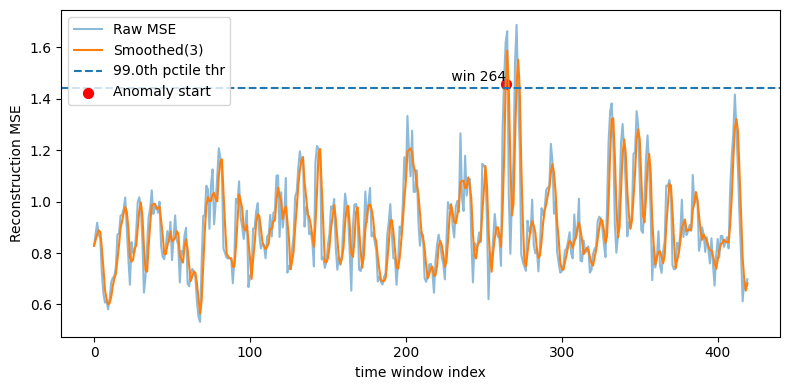

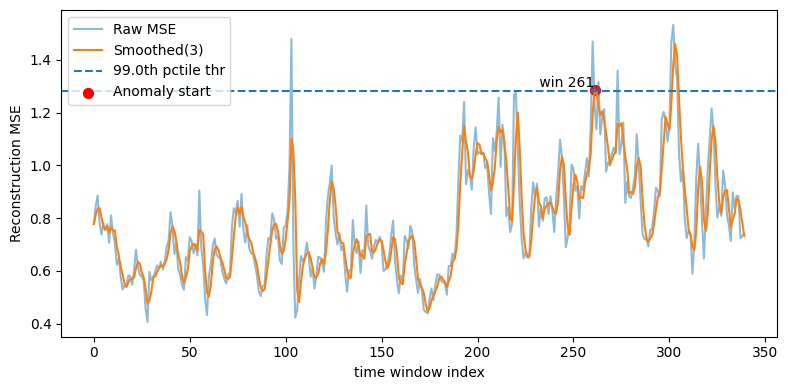

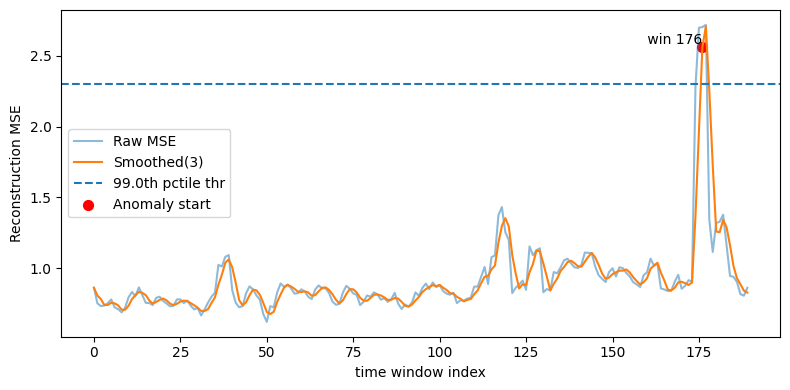

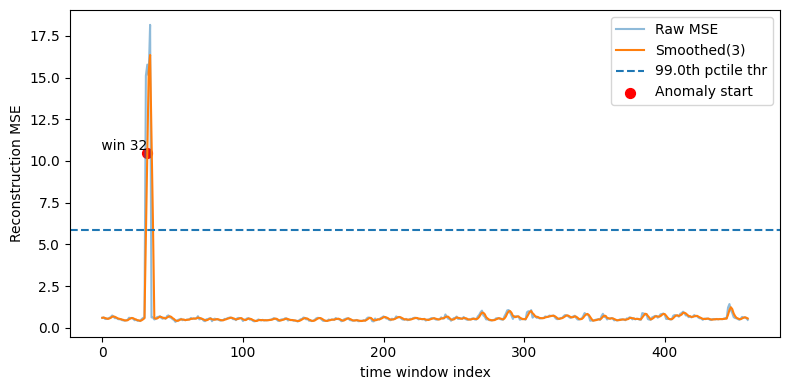

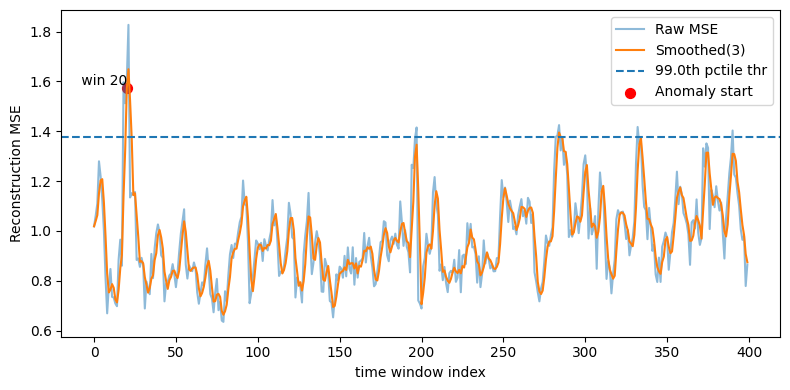

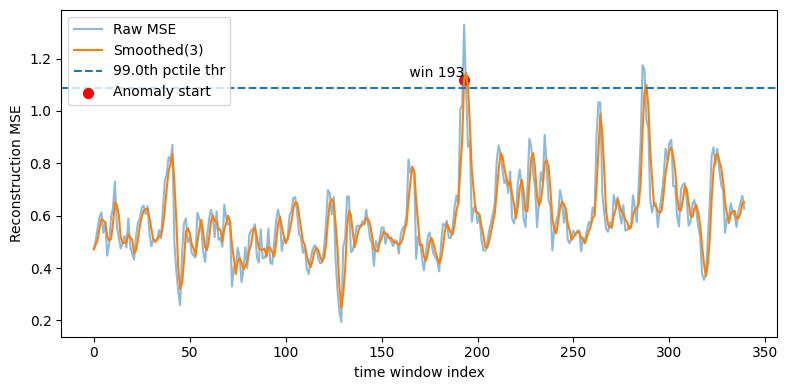

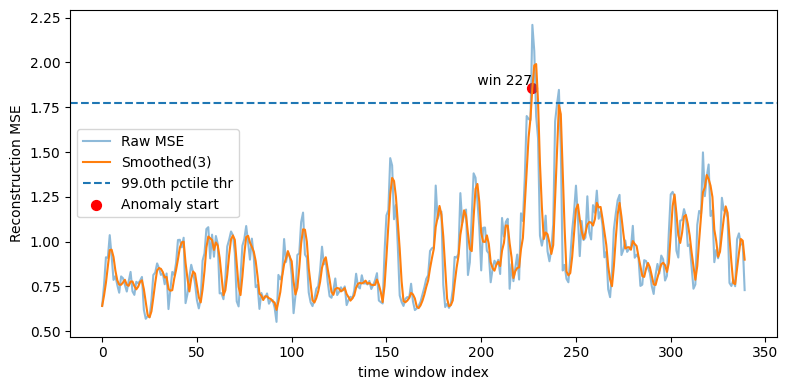

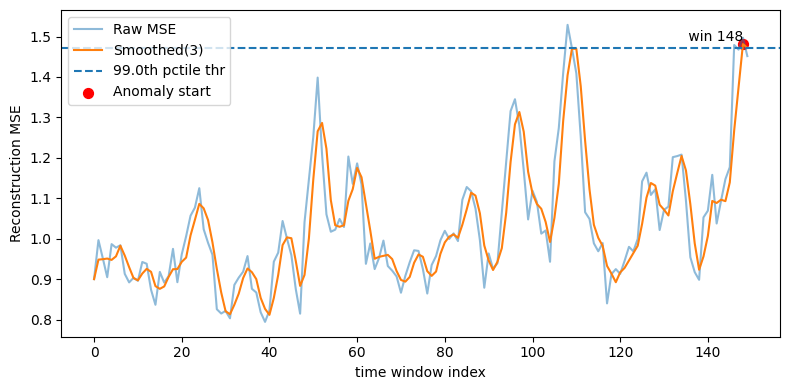

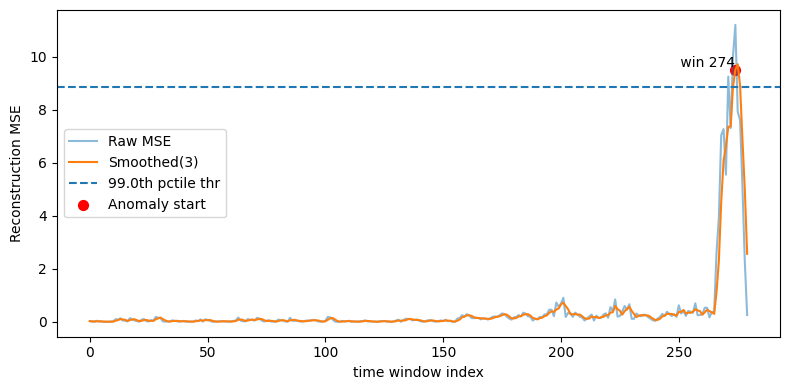

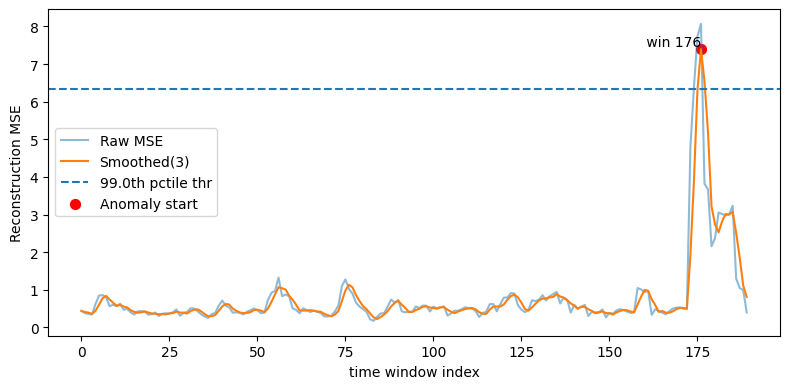

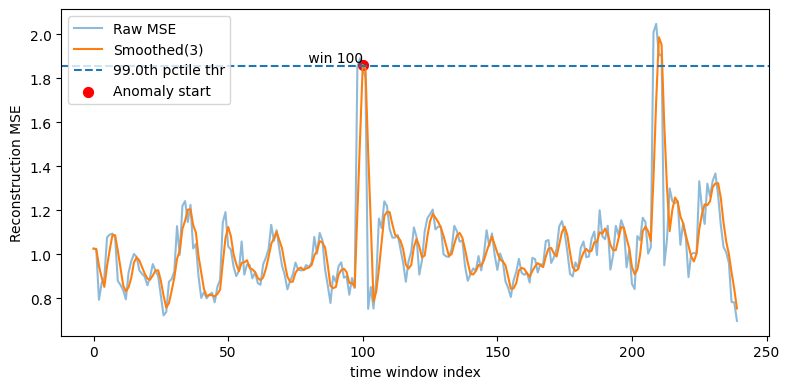

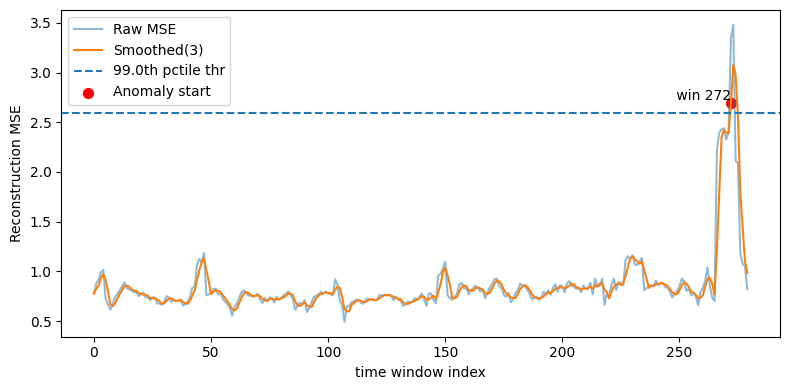

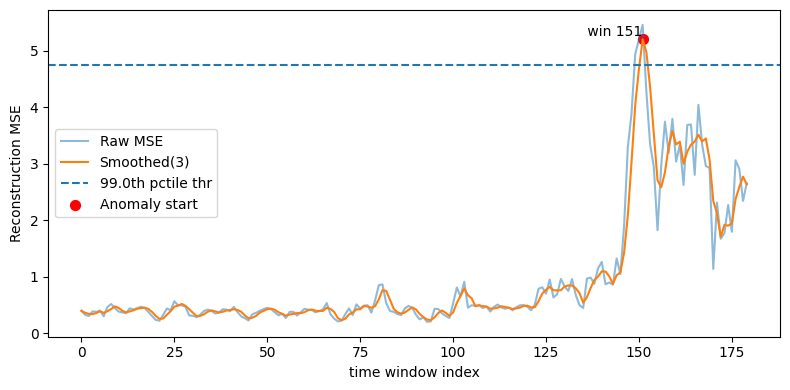

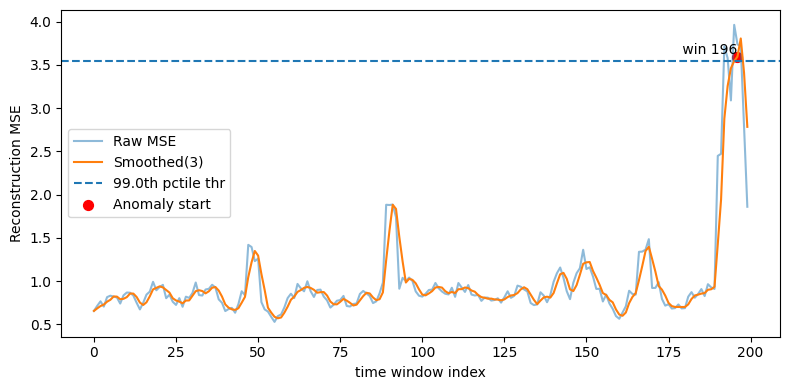

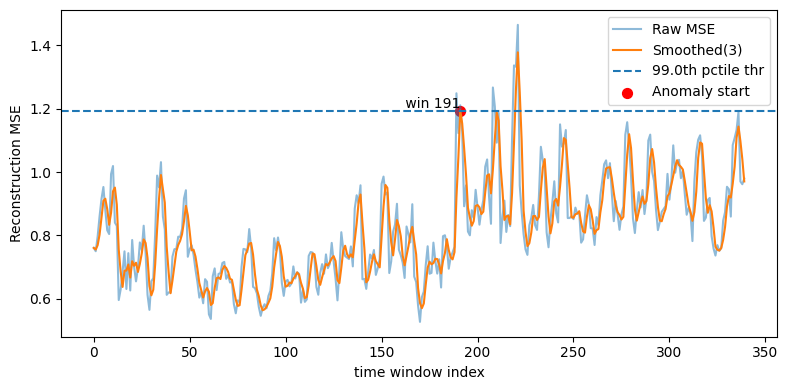

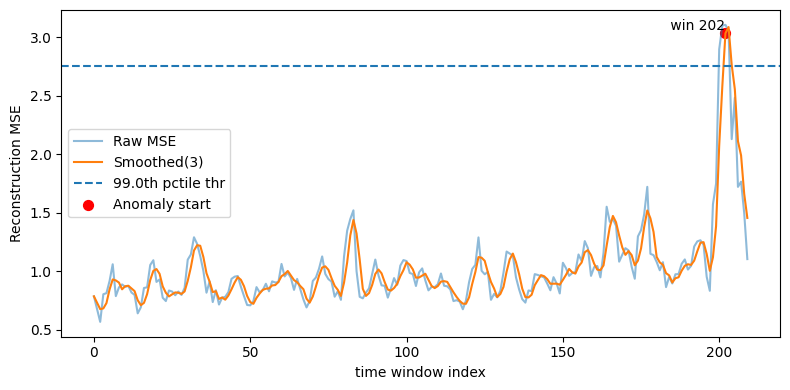

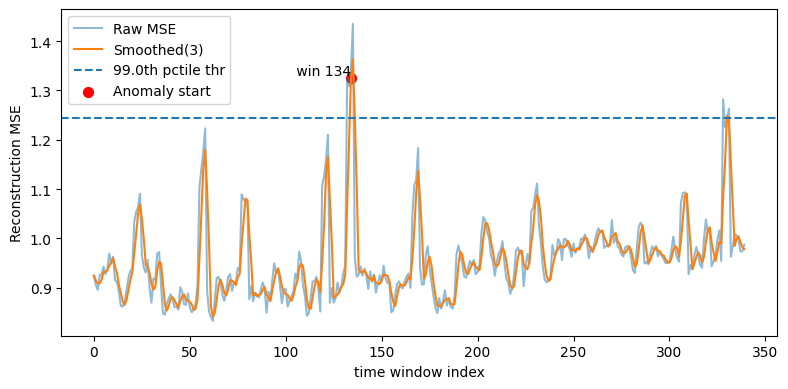

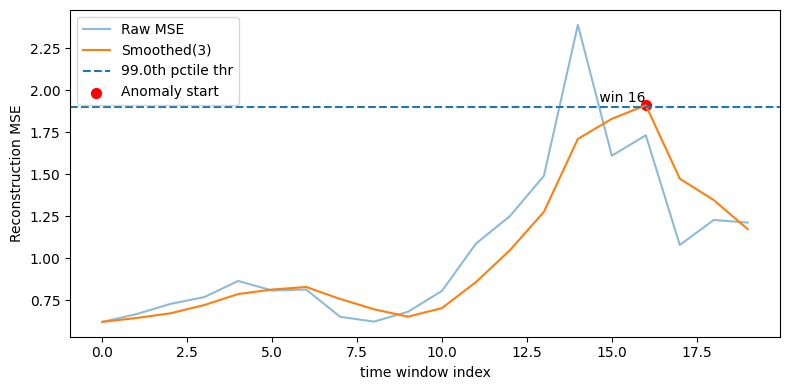

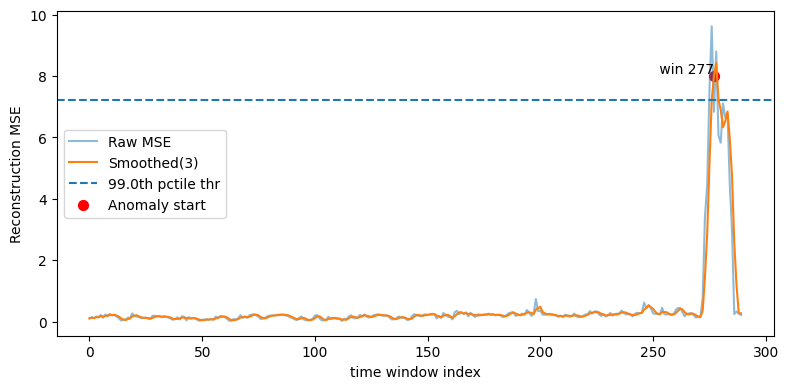

In [8]:
SMOOTH_WINDOW = 3
PCTILE        = 99.0
CONSEC_DAYS =1

def train(files_train,
          save_path,
          files_test,
          predict_save,
          action_length,
          seq_length=4,
          batch_size=16,
          epochs=200,
          val_split=0.2,
          dropout_rate=0.2):
    """
    LSTM autoencoder for action‐sequence reconstruction.
    Args:
      files_train:    data_train.csv (n_windows × seq_length*action_length)
      save_path:      where to save the best .keras model
      files_test:     data_test.csv (same format)
      predict_save:   where to dump reconstruction errors (one MSE per window)
      action_length:  features/day
      seq_length:     days per window
      batch_size:     training batch size
      epochs:         max epochs
      val_split:      fraction for validation
      dropout_rate:   dropout on LSTM layers
    """
    # 1) load
    X = np.loadtxt(files_train, delimiter=',')
    n_windows, tot_feats = X.shape
    assert tot_feats == seq_length * action_length

    # 2) scale
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    # save scaler for later
    import pickle
    scaler_path = os.path.join(os.path.dirname(save_path), 'scaler.pkl')
    with open(scaler_path, 'wb') as f:
       pickle.dump(scaler, f)

    # 3) reshape to (n_windows, seq_length, action_length)
    Xs_seq = Xs.reshape(n_windows, seq_length, action_length)

    # 4) build autoencoder
    inp = Input(shape=(seq_length, action_length))
    x   = LSTM(100, return_sequences=True, activation='tanh',
               dropout=dropout_rate, recurrent_dropout=dropout_rate)(inp)
    x   = LSTM(160, return_sequences=False, activation='tanh',
               dropout=dropout_rate, recurrent_dropout=dropout_rate)(x)
    rep = RepeatVector(seq_length)(x)
    x   = LSTM(160, return_sequences=True, activation='tanh')(rep)
    x   = LSTM(100, return_sequences=True, activation='tanh')(x)
    out = TimeDistributed(Dense(action_length))(x)

    ae = Model(inputs=inp, outputs=out)
    ae.compile(optimizer='adam', loss='mse')

    # 5) callbacks
    ckpt  = ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True, verbose=1)
    early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # 6) train
    ae.fit(
        Xs_seq, Xs_seq,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=val_split,
        shuffle=True,
        callbacks=[ckpt, early],
        verbose=2
    )

    # 7) compute per-window reconstruction MSE on test set
    Xt = np.loadtxt(files_test, delimiter=',')
    Xt_scaled = scaler.transform(Xt)
    n_test = Xt_scaled.shape[0]
    Xt_seq = Xt_scaled.reshape(n_test, seq_length, action_length)

    recons = ae.predict(Xt_seq)             # shape = (n_test, seq_length, action_length)
    # compute MSE per window (mean across all seq_length×action_length)
    mse_per_win = np.mean((recons - Xt_seq)**2, axis=(1,2))

    np.savetxt(predict_save, mse_per_win, fmt='%.6f', delimiter=',')

def my_loss_forFeatures(label_test, predict_save, myloss_save, figure_save):
    y_true = np.loadtxt(label_test, delimiter=',')
    y_pred = np.loadtxt(predict_save, delimiter=',')
    batch_size = np.shape(y_pred)[0]
    All_loss = []
    for i in range(batch_size):
        mse = np.mean(np.square(y_pred[i] - y_true[i]))
        All_loss.append(mse)
    x_list = range(0, batch_size)
    np.savetxt(myloss_save, All_loss, fmt='%f', delimiter=',')
    plt.figure()
    plt.plot(x_list, All_loss)
    plt.show()
    plt.savefig(figure_save)
    print(np.shape(All_loss))

def Calculate_deviations(files_test, loss_save, figure_save,
                         save_path, action_length,
                         seq_length=4,
                         pctile=PCTILE,
                         smooth_w=SMOOTH_WINDOW,
                         consec_days=CONSEC_DAYS):
    """
    Loads the autoencoder and the scaler, reshapes test windows into (seq_length,action_length),
    runs reconstruction, computes per-window MSE, then thresholds + plots.
    """
    # 1) load model + scaler
    ae = load_model(save_path)
    scaler_path = os.path.join(os.path.dirname(save_path), 'scaler.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 2) load flat test‐windows
    X_flat = np.loadtxt(files_test, delimiter=',')           # shape (n_windows, seq_length*action_length)
    n_windows, tot = X_flat.shape
    assert tot == seq_length * action_length

    # 3) rescale & reshape
    Xs = scaler.transform(X_flat)
    X_seq = Xs.reshape(n_windows, seq_length, action_length)

    # 4) reconstruct & compute per‐window MSE
    recons = ae.predict(X_seq, verbose=0)                     # (n_windows, seq_length, action_length)
    mse    = np.mean((recons - X_seq)**2, axis=(1,2))        # (n_windows,)

    # 5) save raw losses
    np.savetxt(loss_save, mse, fmt='%.6f', delimiter=',')

    # 6) threshold + detect first anomaly
    sm = pd.Series(mse).rolling(window=smooth_w, min_periods=1).mean().values
    thr = np.percentile(sm[smooth_w:], pctile)
    start = detect_anomaly_start(sm, thr, consec_days)
    print(f"✦ {USERNAME} anomaly at window {start} (thr={thr:.4f})")

    # 7) plot
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(mse,    alpha=0.5, label='Raw MSE')
    ax.plot(sm,      label=f'Smoothed({smooth_w})')
    ax.axhline(thr, linestyle='--', label=f'{pctile}th pctile thr')
    if start is not None:
        ax.scatter(start, sm[start], c='r', s=50, label='Anomaly start')
        ax.text(start, sm[start], f' win {start}', va='bottom', ha='right')
    ax.set_xlabel('time window index')
    ax.set_ylabel('Reconstruction MSE')
    ax.legend()
    fig.tight_layout()
    fig.savefig(figure_save)

if __name__ == "__main__":
    for username, length in user_max_length.items():
        USERNAME = username
        action_length = length

        # 1) Skip users with zero sequence length
        if action_length == 0:
            print(f"⚠️  Skipping {USERNAME}: no action sequence data.")
            continue

        # 2) Build all of our paths
        base = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
        folder = os.path.join(base, USERNAME, 'Model', 'Action')
        files_train   = os.path.join(base, USERNAME, 'sequence', 'data_train.csv')
        labels_train  = os.path.join(base, USERNAME, 'sequence', 'label_train.csv')
        files_test    = os.path.join(base, USERNAME, 'sequence', 'data_test.csv')
        predict_save  = os.path.join(base, USERNAME, 'sequence', 'predict.csv')
        save_path     = os.path.join(folder, 'model.keras')
        loss_save     = os.path.join(base, USERNAME, 'sequence', 'loss.csv')
        figure_save   = os.path.join(base, USERNAME, 'sequence', 'loss.jpg')

        # 3) Skip if any of the key CSVs don’t exist
        missing = [p for p in (files_train, labels_train, files_test) if not os.path.isfile(p)]
        if missing:
            print(f"⚠️  Skipping {USERNAME}: missing {missing}")
            continue

        path_check(folder)

        # 4) Train & predict
        train(files_train,
              save_path,
              files_test,
              predict_save,
              action_length)
        if not os.path.isfile(save_path):
            print(f"⚠️  No model found for {USERNAME} (skipping deviation).")
            continue

        # 5) Compute the losses over all data
        predict_all   = os.path.join(base, USERNAME, 'sequence', 'predict_all.csv')
        data_all      = os.path.join(base, USERNAME, 'sequence', 'data_all.csv')
        label_all     = os.path.join(base, USERNAME, 'sequence', 'label_all.csv')
        loss_all_save = os.path.join(base, USERNAME, 'sequence', 'loss_all.csv')
        fig_all_save  = os.path.join(base, USERNAME, 'sequence', 'loss_all.jpg')

        # skip again if those don't exist
        missing2 = [p for p in (data_all, label_all) if not os.path.isfile(p)]
        if missing2:
            print(f"⚠️  Skipping deviation calc for {USERNAME}: missing {missing2}")
            continue

        Calculate_deviations(
        files_test = data_all,
        loss_save  = loss_all_save,
        figure_save= fig_all_save,
        save_path  = save_path,
        action_length=action_length
    )
        
        


# Static Feature Training

Parallel to the sequence model, this section trains a classifier, solely on snapshot features: overall counts, demographics, or aggregate statistics. Evaluating performance on static features establishes a baseline, helping to quantify precisely how much the sequential modeling adds on top of what can be gleaned from one-time summary data.


Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Model/Feature ' successfully!
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3452 - loss: 2697.2000
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8936 - loss: 2391.4958
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9101 - loss: 2381.8135
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9307 - loss: 2354.2825
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9227 - loss: 2392.2312
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9220 - loss: 2341.4607
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9221 - loss: 2372.9185
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9064 - loss: 2303.6697
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9328 - loss: 2340.2803
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9219 - loss: 2301.8726
Epoch 1

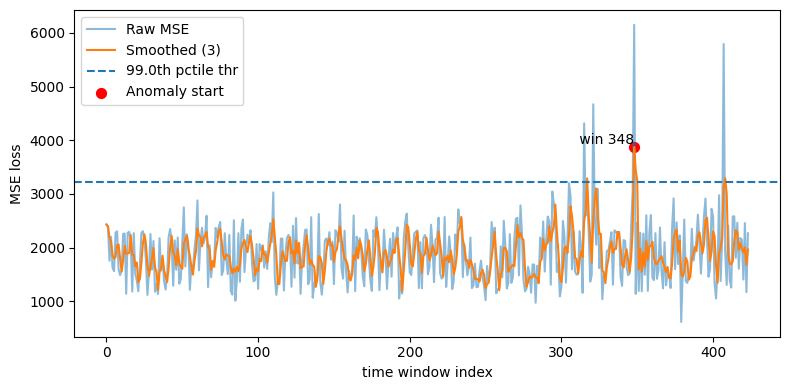

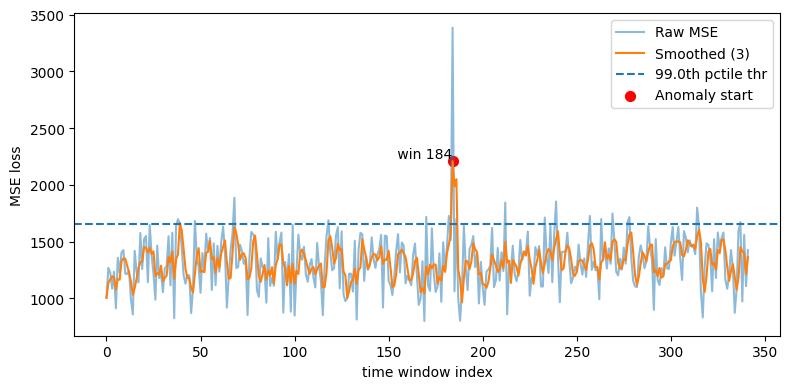

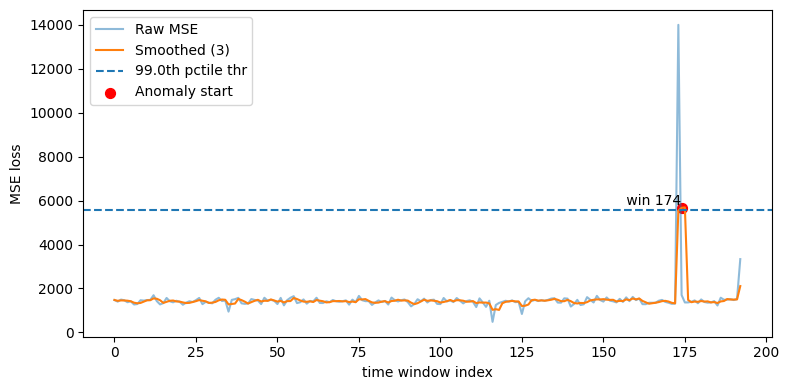

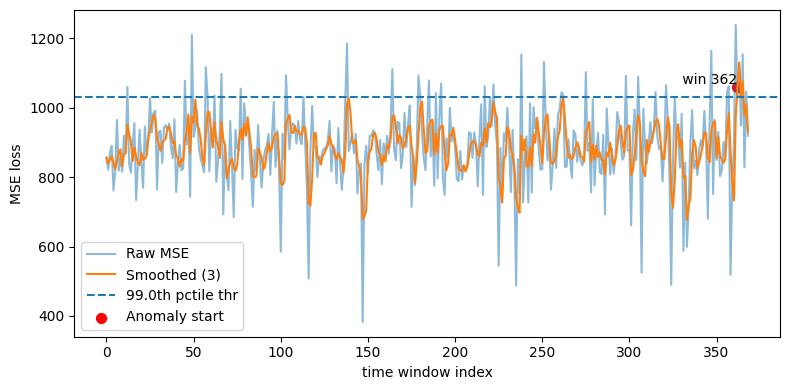

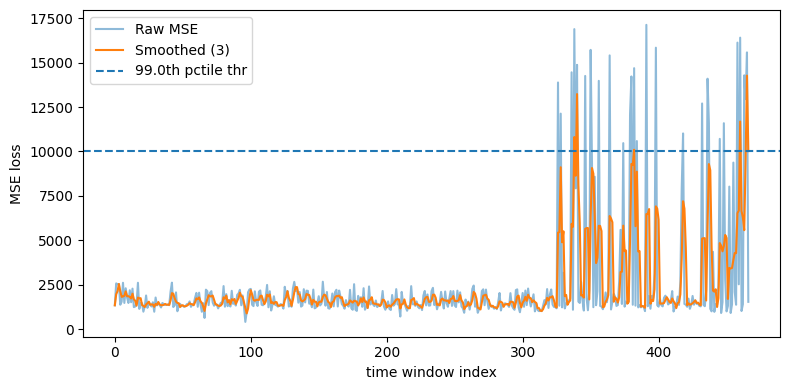

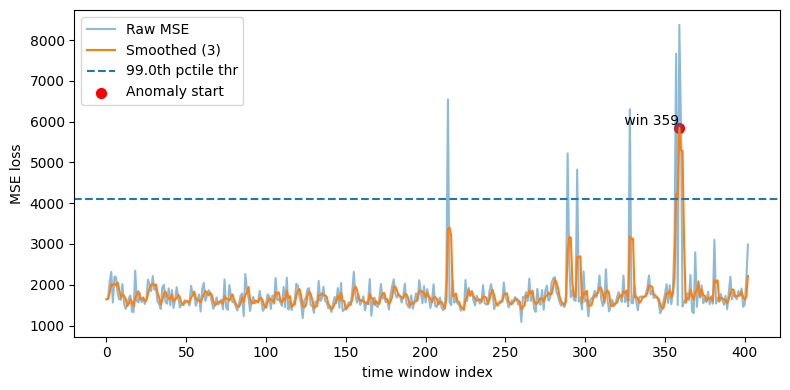

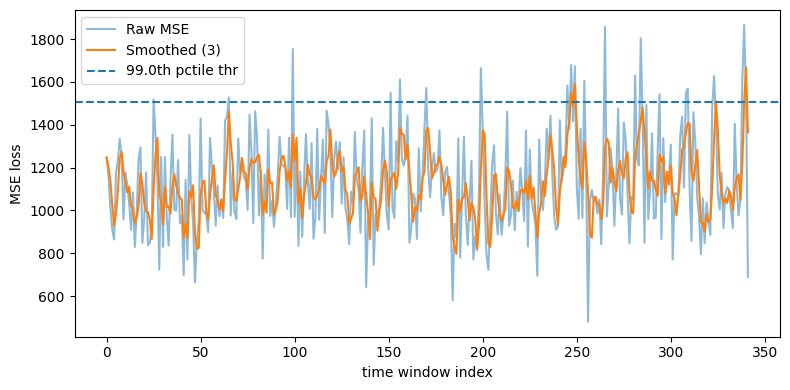

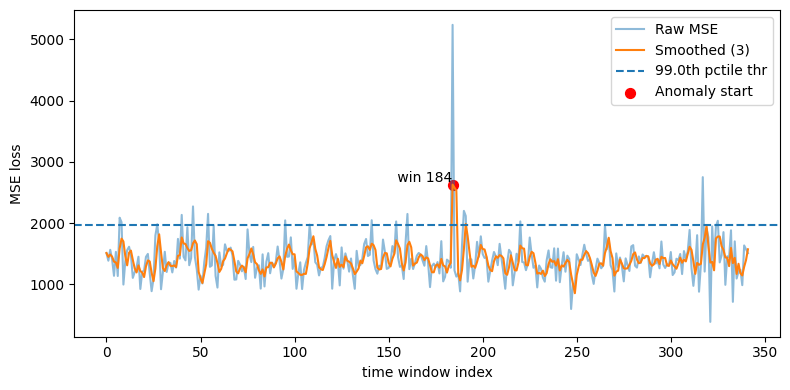

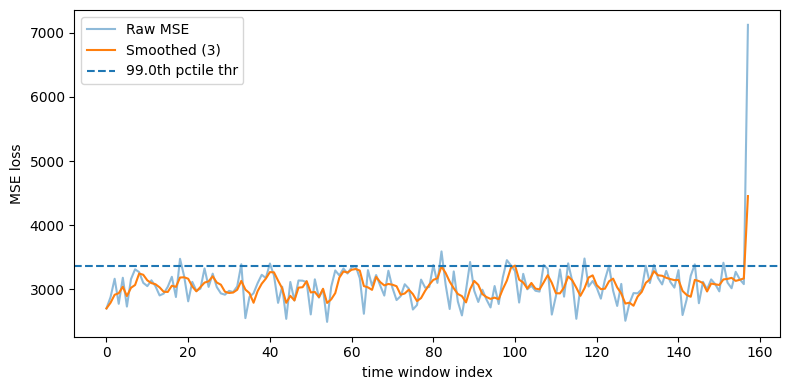

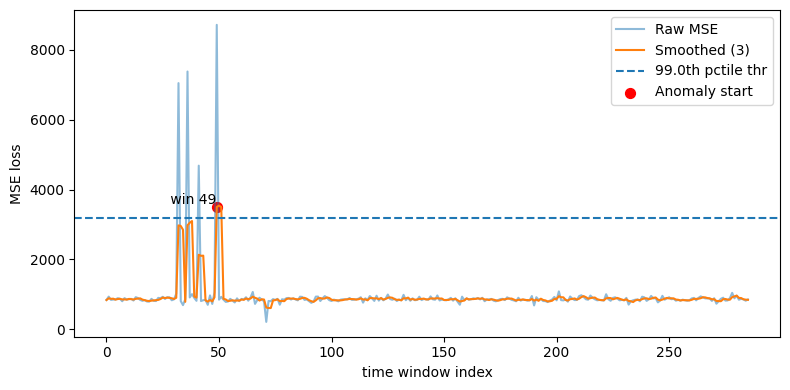

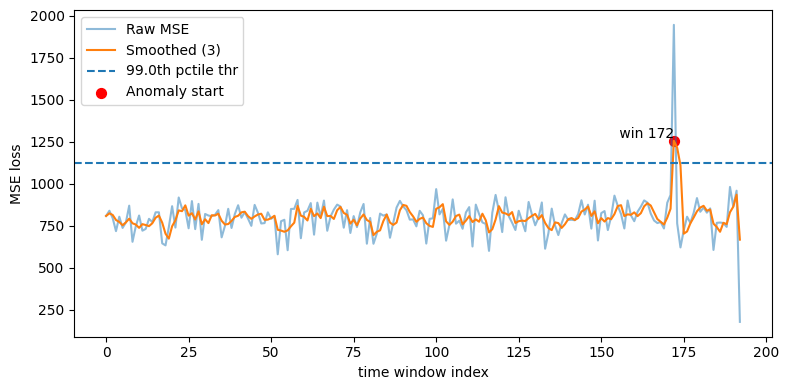

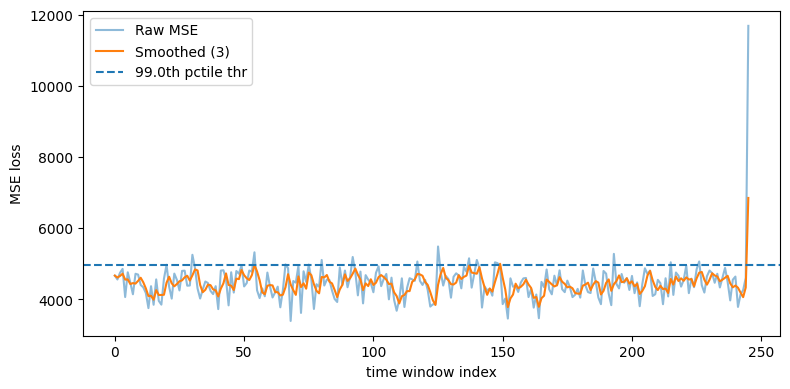

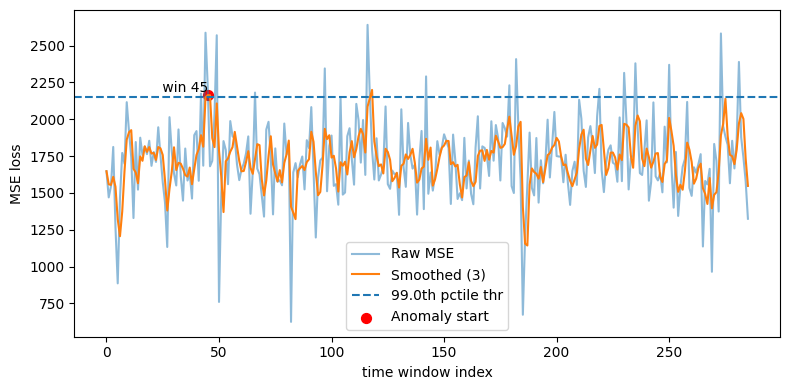

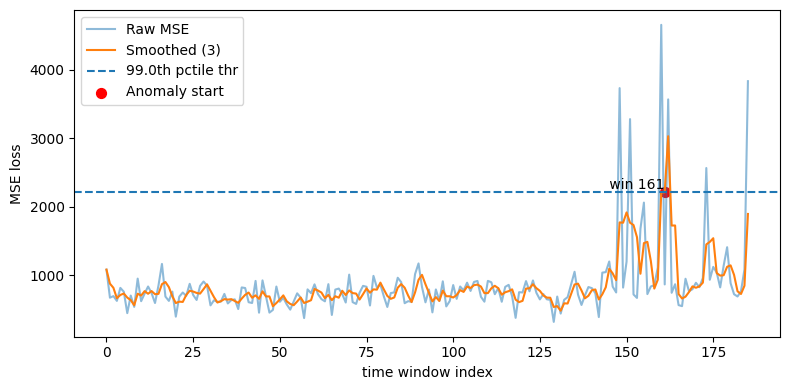

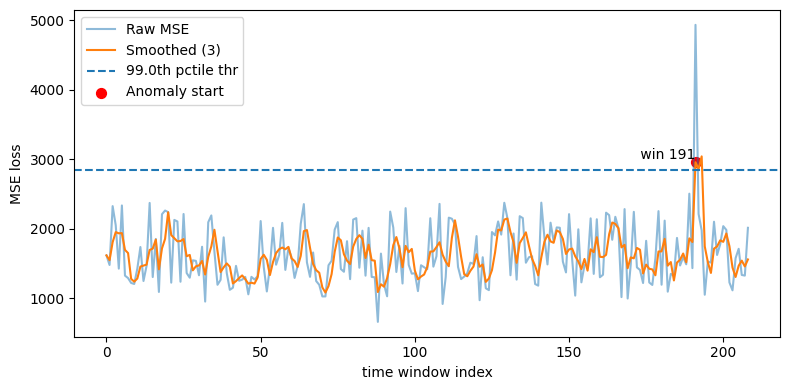

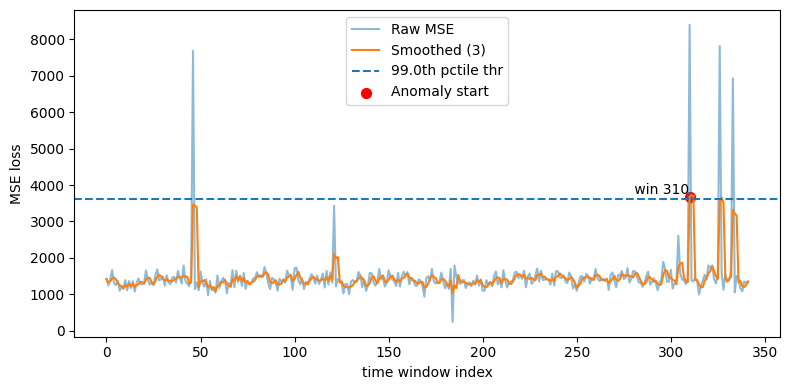

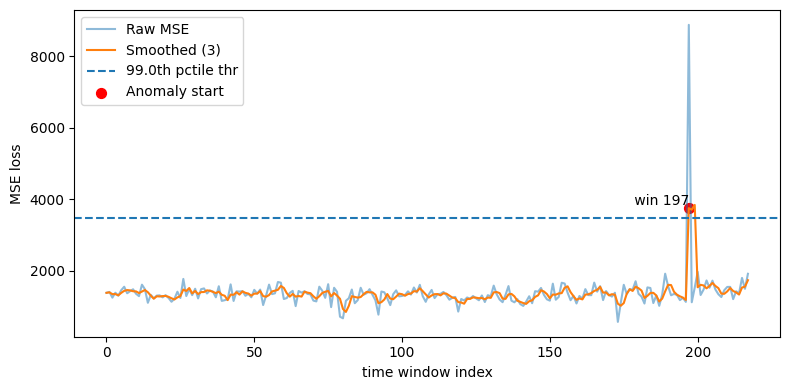

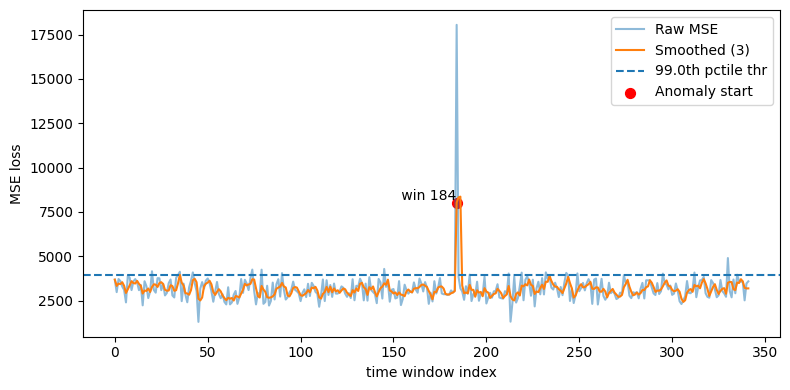

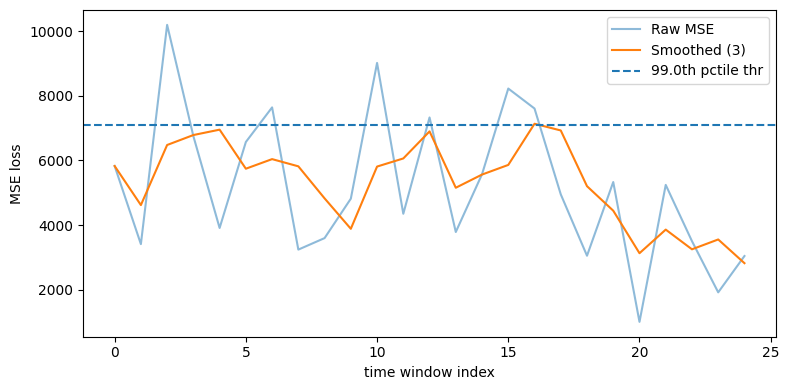

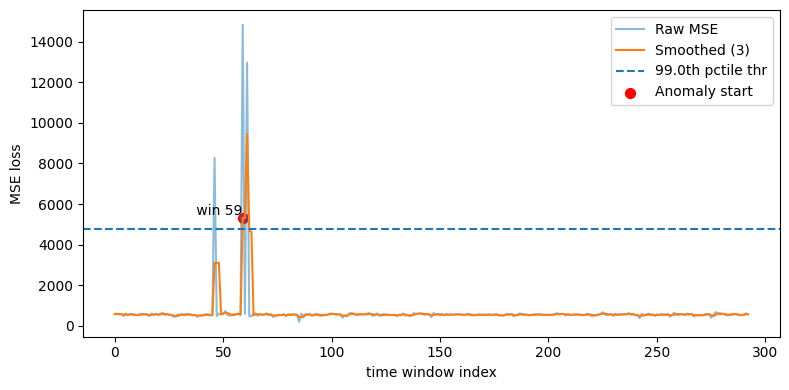

In [9]:
WINDOW        = 5
PCTILE        = 99.0
SMOOTH_WINDOW = 3
CONSEC_DAYS   = 2

def data_generator(files_name, num_days=5, batch_size=200):
    counts = count_line(files_name) - 1
    real_counts = counts - num_days + 1
    rounds = int(real_counts / batch_size)
    while (1):
        for i in range(rounds):
            data_batch = []
            label_batch = []
            for j in range(batch_size):
                data_index = i + j + 1
                label_index = data_index + 4
                data_one = linecache.getline(files_name, data_index).strip().split(',') + \
                           linecache.getline(files_name, data_index + 1).strip().split(',') + \
                           linecache.getline(files_name, data_index + 2).strip().split(',') + \
                           linecache.getline(files_name, data_index + 3).strip().split(',')
                labe_data = linecache.getline(files_name, label_index).strip().split(',')
                data_batch.append(data_one)
                label_batch.append(labe_data)
            data_batch = np.array(data_batch)
            label_batch = np.array(label_batch)
            data_out  = data_batch.reshape(batch_size, 4 * num_feats)
            label_out = label_batch.reshape(batch_size,     num_feats)

            i = i + batch_size + 1
            yield data_out, label_out

def train(files_train, labels_train, save_path, files_test, predict_save):
    x_train = np.loadtxt(files_train, delimiter=',')
    lo_psy, hi_psy = np.percentile(x_train[:,2], [5, 95])
    x_train[:,2] = np.clip(x_train[:,2], lo_psy, hi_psy)


    y_train = np.loadtxt(labels_train, delimiter=',')
    num_feats = x_train.shape[1] // 4

    main_input = Input(shape=(4 * num_feats,), dtype='float32', name='MainInput')
    Inputs     = Reshape((4, num_feats))(main_input)
    layer      = GRU(100, return_sequences=True, activation='tanh')(Inputs)
    layer      = GRU(160, return_sequences=False, activation='tanh')(layer)
    output     = Dense(num_feats, activation='relu')(layer)
    model      = Model(inputs=main_input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    tensorboard_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/' + USERNAME + '/Model/Feature'
    tbCallback = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_metadata=None)
    checkpoint = ModelCheckpoint(save_path, monitor='loss', verbose=0, save_best_only='True')
    model.fit(x_train, y_train, batch_size=6, epochs=100, shuffle=True, callbacks=[tbCallback, checkpoint])

    x_test = np.loadtxt(files_test, delimiter=',')
    y_pred = model.predict(x_test)
    np.savetxt(predict_save, y_pred, fmt='%f', delimiter=',')


def test(files_test, save_path, predict_save):
    x_test = np.loadtxt(files_test, delimiter=',')
    model = load_model(save_path)
    pred = model.predict(x_test)
    pred = np.where(pred > 0.47, pred, 0)
    np.savetxt(predict_save, pred, fmt='%f', delimiter=',')
    return pred
def my_loss_forFeatures(label_test, predict_save, myloss_save, figure_save):
    y_true = np.loadtxt(label_test, delimiter=',')
    y_pred = np.loadtxt(predict_save, delimiter=',')
    batch_size = np.shape(y_pred)[0]
    All_loss = []
    for i in range(batch_size):
        mse = np.mean(np.square(y_pred[i] - y_true[i]))
        All_loss.append(mse)
    x_list = range(0, batch_size)
    np.savetxt(myloss_save, All_loss, fmt='%f', delimiter=',')

def Calculate_deviations(files_test, label_test, save_path, loss_save, figure_save,
                         window=WINDOW, pctile=PCTILE, smooth_w=SMOOTH_WINDOW,
                         consec_days=CONSEC_DAYS):
    # Load true/pred and compute per‐sample MSE loss
    x_test = np.loadtxt(files_test, delimiter=',')
    lo_psy, hi_psy = np.percentile(x_test[:,2], [5, 95])
    x_test[:,2] = np.clip(x_test[:,2], lo_psy, hi_psy)
    
    y_test = np.loadtxt(label_test, delimiter=',')
    num_feats = x_test.shape[1] // 4
    model = load_model(save_path)

    All_loss = []
    for i in range(len(x_test)):
        x_i = x_test[i].reshape(1, 4 * num_feats)
        y_i = y_test[i].reshape(1,     num_feats)
        loss, _ = model.evaluate(x=x_i, y=y_i, verbose=0)
        All_loss.append(loss)
    All_loss = np.array(All_loss)
    np.savetxt(loss_save, All_loss, fmt='%.6f', delimiter=',')

    # --- compute smoothed errors, threshold, and first anomaly ---
    # rolling smoothing
    smoothed = pd.Series(All_loss).rolling(window=smooth_w, min_periods=1).mean().values
    # percentile threshold on smoothed, skipping the first 'window' points
    thr = np.percentile(smoothed[window:], pctile)
    # detect first run of consec_days above threshold
    start = detect_anomaly_start(smoothed, thr, consec_days)

    # --- plotting just like psychometric code ---
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(All_loss,     alpha=0.5, label='Raw MSE')
    ax.plot(smoothed,     label=f'Smoothed ({smooth_w})')
    ax.axhline(thr, linestyle='--', label=f'{pctile}th pctile thr')
    if start is not None:
        ax.scatter(start, smoothed[start], c='r', s=50, label='Anomaly start')
        ax.text(start, smoothed[start], f' win {start}', va='bottom', ha='right')
    ax.set_xlabel('time window index')
    ax.set_ylabel('MSE loss')
    ax.legend()
    fig.tight_layout()

    # save and (optional) show
    fig.savefig(figure_save, dpi=150)
    # plt.show()

    return All_loss

def main():
    user_anomaly_start = {}
    consecutive_days  = 3
    base = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'

    for USERNAME in user_max_length:
        # ——————————————————————————————————————————————
        # 1) build all the file paths
        folder       = os.path.join(base, USERNAME, 'Model',   'Feature')
        files_train  = os.path.join(base, USERNAME, 'feature', 'data_train.csv')
        labels_train = os.path.join(base, USERNAME, 'feature', 'label_train.csv')
        files_test   = os.path.join(base, USERNAME, 'feature', 'data_test.csv')
        labels_test  = os.path.join(base, USERNAME, 'feature', 'label_test.csv')
        files_all    = os.path.join(base, USERNAME, 'feature', 'data_all.csv')
        labels_all   = os.path.join(base, USERNAME, 'feature', 'label_all.csv')
        save_path    = os.path.join(base, USERNAME, 'Model',   'Feature', 'model.keras')

        # 2) skip if any of these is missing
        missing = [
            p for p in
            (files_train, labels_train, files_test, labels_test, files_all, labels_all)
            if not os.path.isfile(p)
        ]
        if missing:
            print(f"⚠️  Skipping {USERNAME}: missing {missing}")
            continue

        # 3) ensure model folder exists
        path_check(folder)

        # 4) train, retrain, test & compute raw losses
        train( files_train,  labels_train, save_path,
               files_test,  predict_save=os.path.join(base,USERNAME,'feature','predict.csv'))
        test(   files_test,   save_path,
               predict_save=os.path.join(base,USERNAME,'feature','predict_all.csv'))
        Calculate_deviations(
            files_test=files_all,
            label_test=labels_all,
            save_path=save_path,
            loss_save=os.path.join(base,USERNAME,'feature','loss_all.csv'),
            figure_save=os.path.join(base,USERNAME,'feature','loss_all.jpg')
        )

        # 5) compute “myloss” then detect anomaly start
        my_loss_forFeatures(
            label_test=labels_all,
            predict_save=os.path.join(base,USERNAME,'feature','predict_all.csv'),
            myloss_save=os.path.join(base,USERNAME,'feature','myloss_all.csv'),
            figure_save=os.path.join(base,USERNAME,'feature','myloss_all.jpg')
        )

        # ——————————————————————————————————————————————
        # 6) Read the loss file with NO header, and debug‐print its contents
        loss_file_path = os.path.join(base,USERNAME,'feature','loss_all.csv')
        df     = pd.read_csv(loss_file_path, header=None)
        losses = df.iloc[:,0].values

        print(f"\n--- {USERNAME} LOSS DEBUG ---")
        print(f"  file:            {loss_file_path}")
        print(f"  days read:       {len(losses)}")
        print(f"  first  5 losses: {losses[:5]}")
        print(f"  last   5 losses: {losses[-5:]}")

        # 7) threshold and detection
        smoothed = pd.Series(losses).rolling(window=SMOOTH_WINDOW, min_periods=1).mean().values
        thr      = np.percentile(smoothed[WINDOW:], PCTILE)
        start    = detect_anomaly_start(smoothed, thr, CONSEC_DAYS)
        print(f"{USERNAME}: threshold={thr:.4f}, first anomaly at={start}")
        if start is not None:
            user_anomaly_start[USERNAME] = start
            print(f"✓  {USERNAME} anomaly from day {start}")
        else:
            print(f"–  {USERNAME} no anomaly")

    return user_anomaly_start

if __name__ == "__main__":
    user_anomaly_start = main()
    print("\nDictionary of anomaly starts:", user_anomaly_start)




# Psycometric Feature training

In this part, the focus shifts to psychometric or survey-derived variables—personality scores, self-report scales, etc. The code trains and evaluates yet another model branch on these features. This comparison is important because it reveals whether self-reported traits carry predictive power beyond observed behavior, and it may guide decisions about the necessity or sufficiency of collecting such sensitive information.

▶ Processing NGC0058
Epoch 1/200
27/27 - 5s - 200ms/step - loss: 0.9623
Epoch 2/200
27/27 - 0s - 12ms/step - loss: 0.8562
Epoch 3/200
27/27 - 0s - 10ms/step - loss: 0.8174
Epoch 4/200
27/27 - 0s - 7ms/step - loss: 0.8079
Epoch 5/200
27/27 - 0s - 8ms/step - loss: 0.8001
Epoch 6/200
27/27 - 0s - 7ms/step - loss: 0.7884
Epoch 7/200
27/27 - 0s - 11ms/step - loss: 0.7623
Epoch 8/200
27/27 - 0s - 8ms/step - loss: 0.7308
Epoch 9/200
27/27 - 0s - 7ms/step - loss: 0.7030
Epoch 10/200
27/27 - 0s - 12ms/step - loss: 0.6764
Epoch 11/200
27/27 - 0s - 8ms/step - loss: 0.6448
Epoch 12/200
27/27 - 0s - 7ms/step - loss: 0.6235
Epoch 13/200
27/27 - 0s - 8ms/step - loss: 0.6025
Epoch 14/200
27/27 - 0s - 7ms/step - loss: 0.5810
Epoch 15/200
27/27 - 0s - 7ms/step - loss: 0.5589
Epoch 16/200
27/27 - 0s - 8ms/step - loss: 0.5339
Epoch 17/200
27/27 - 0s - 7ms/step - loss: 0.5126
Epoch 18/200
27/27 - 0s - 7ms/step - loss: 0.4886
Epoch 19/200
27/27 - 0s - 7ms/step - loss: 0.4662
Epoch 20/200
27/27 - 0s - 7ms/st

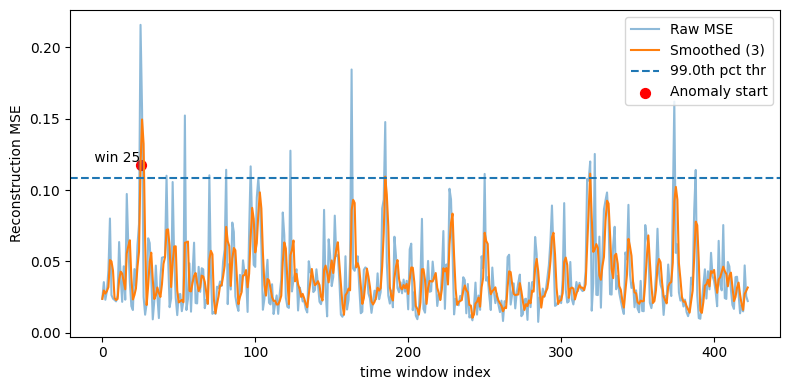

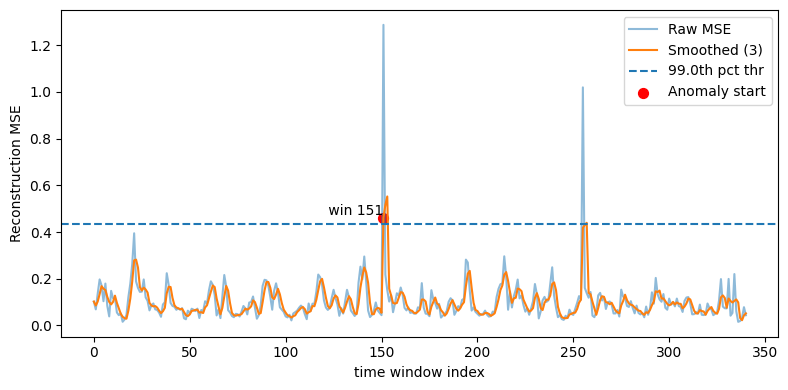

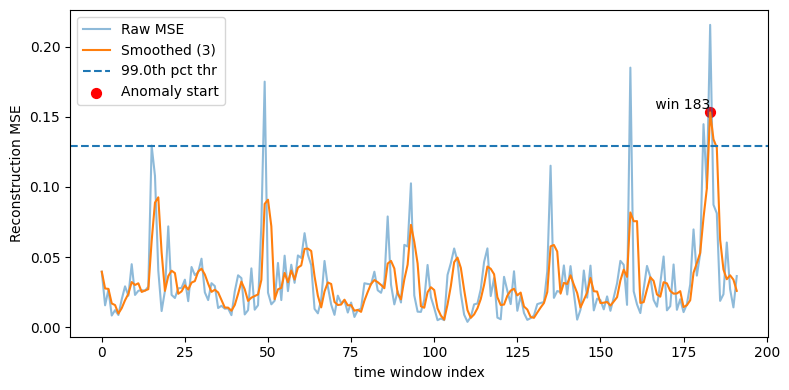

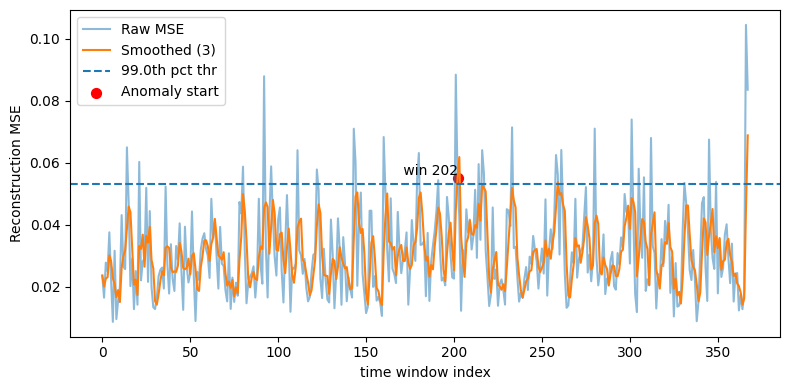

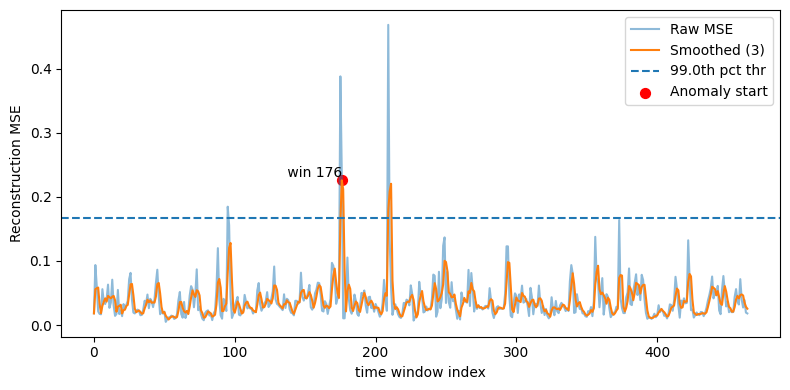

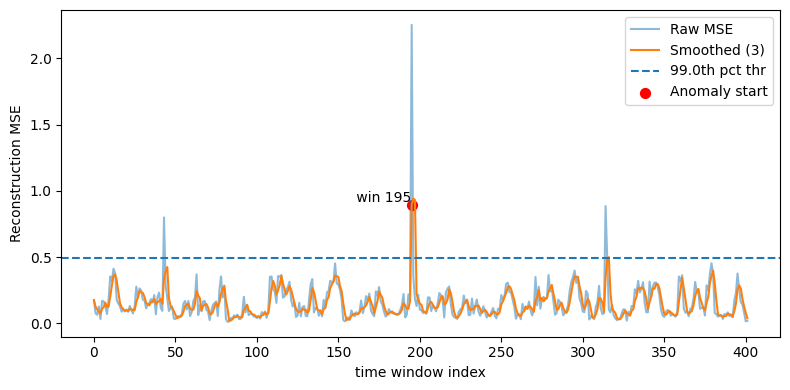

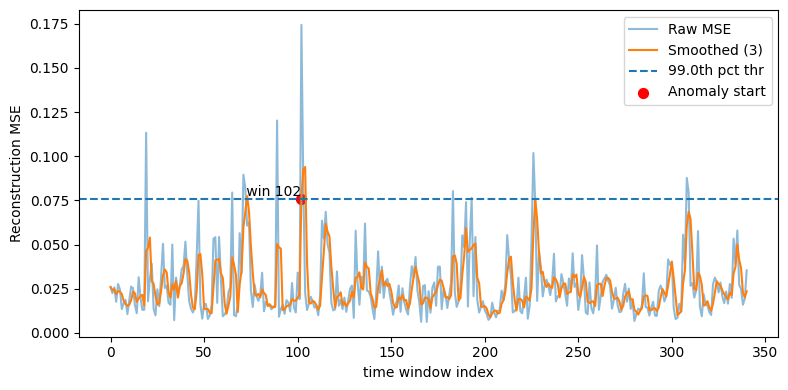

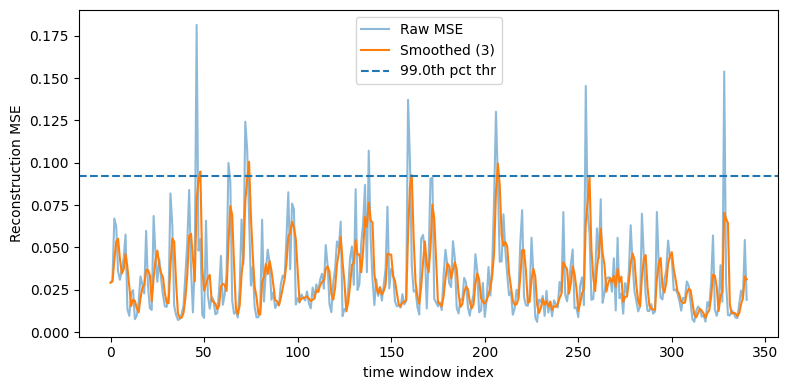

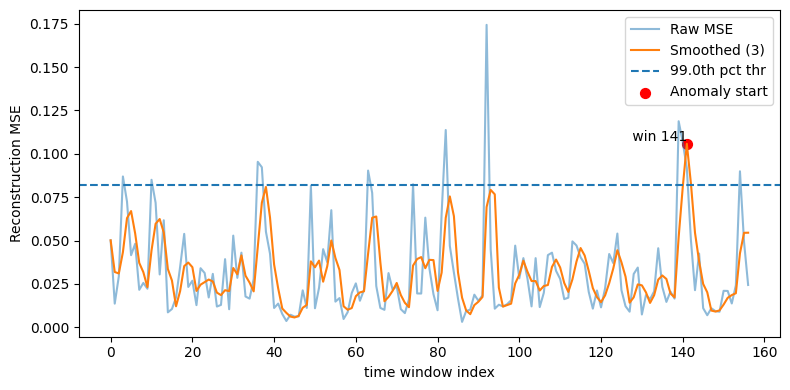

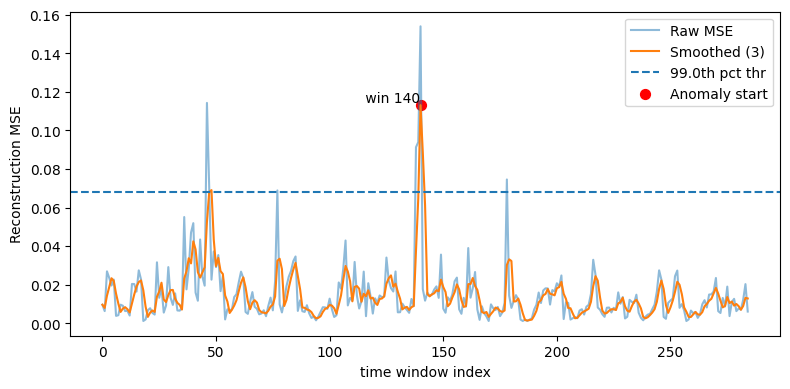

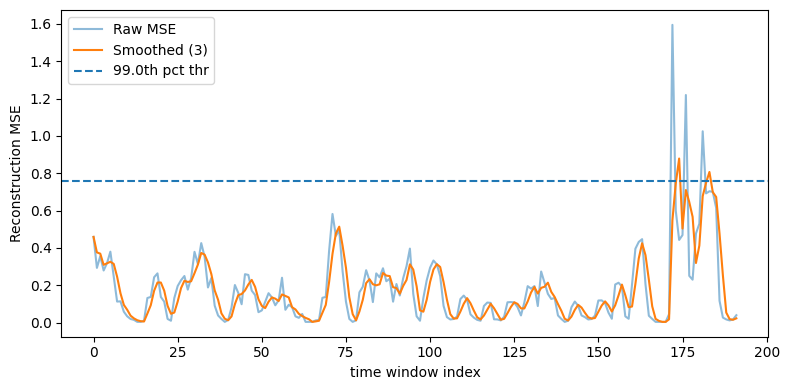

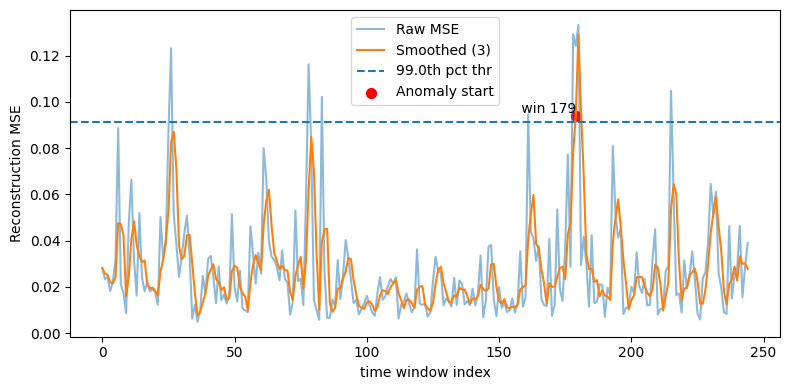

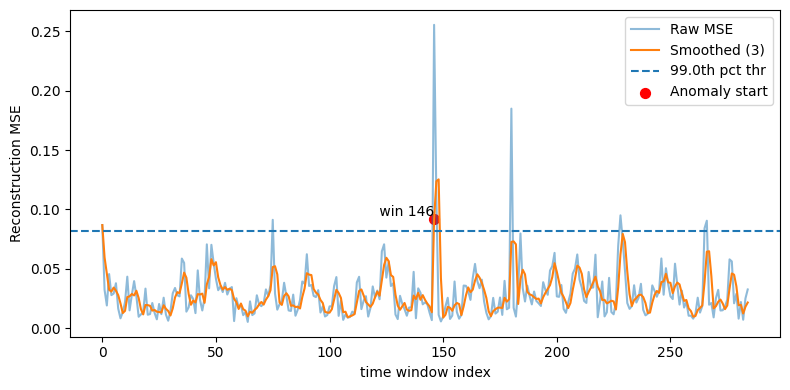

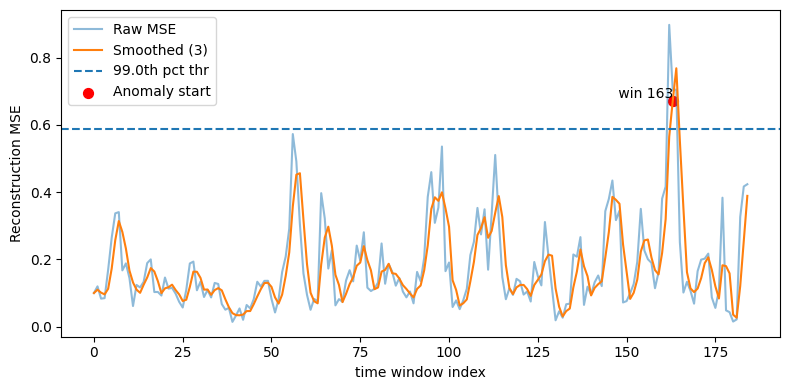

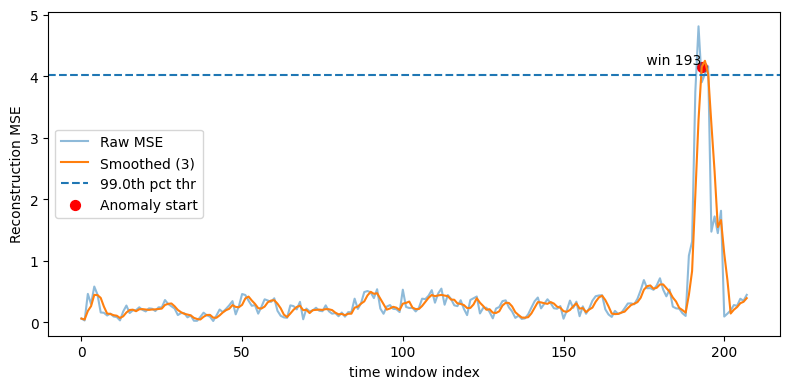

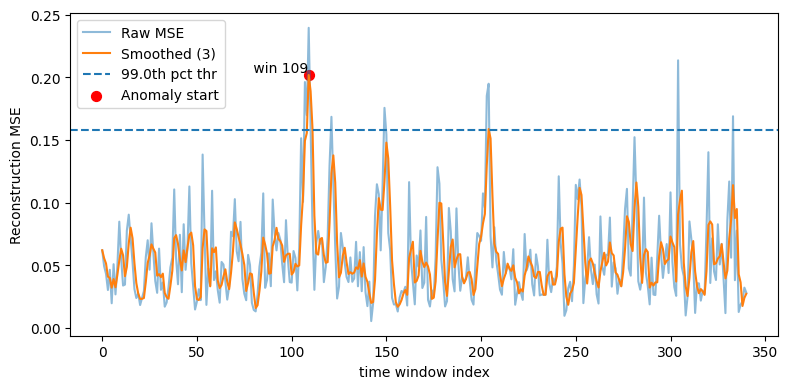

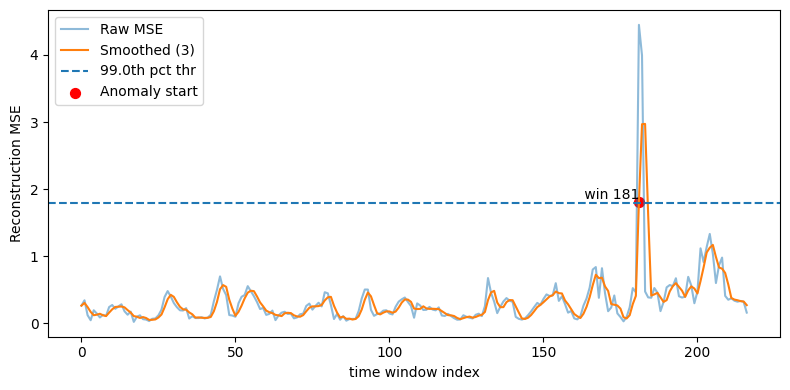

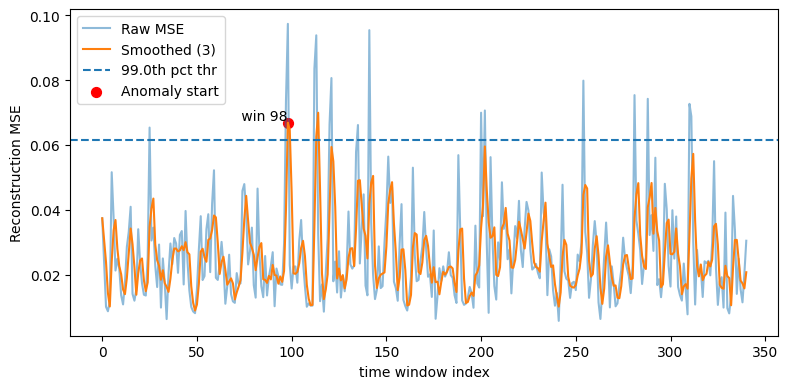

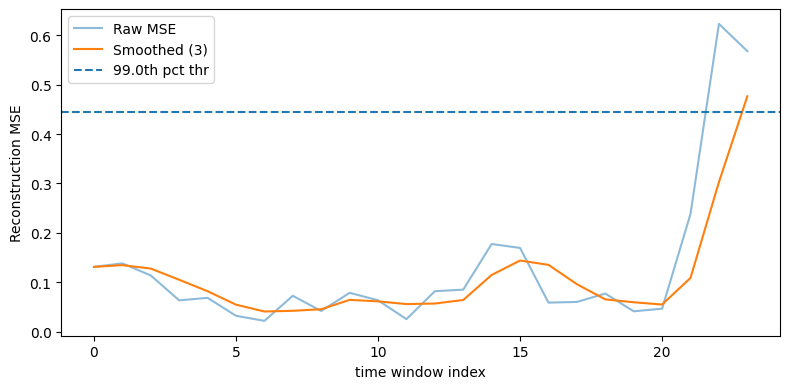

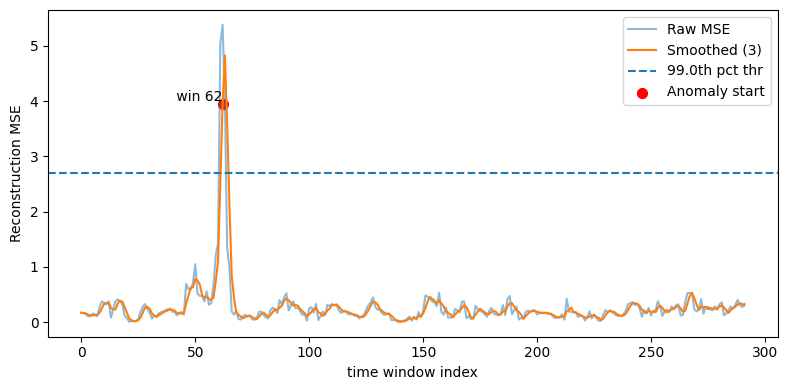

In [10]:


BASE = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
WINDOW        = 5     # number of days per window
EPOCHS        = 200   # training epochs
BATCH_SIZE    = 16
PCTILE        = 99.0  # percentile for threshold
CONSEC_DAYS   = 2     # consecutive windows required for anomaly
SMOOTH_WINDOW = 3     # smoothing window size
figs = []

def percentile_threshold(errors, pct=99.0):
    """Return the pct-th percentile of the error array."""
    return np.percentile(errors, pct)

def detect_anomaly_run(errors, threshold, window_size, consec_req=2):
    """
    Find the first index >= window_size where errors exceed threshold for consec_req windows.
    """
    consec = 0
    start = None
    for i in range(window_size, len(errors)):
        if errors[i] > threshold:
            consec += 1
            if consec >= consec_req:
                start = i - consec_req + 1
                break
        else:
            consec = 0
    return start

# Gather user list
user_names = [d for d in os.listdir(BASE) if os.path.isdir(os.path.join(BASE, d))]

def train_autoencoder(USERNAME, window=WINDOW, epochs=EPOCHS):
    # Load and normalize
    sf_path = os.path.join(BASE, USERNAME, 'feature', 'social', 'social_out.csv')
    sf = pd.read_csv(sf_path, header=None,
                     names=['day'] + [f's{i}' for i in range(6)]).set_index('day')
    scaler = StandardScaler()
    data = scaler.fit_transform(sf.values)

    # Build sliding windows
    X = np.array([data[i:i+window] for i in range(len(data) - window)])

    # Autoencoder architecture
    inp = Input(shape=(window, 6), name='encoder_input')
    enc = LSTM(64, activation='tanh', name='encoder_lstm')(inp)
    rep = RepeatVector(window, name='repeat_vector')(enc)
    dec = LSTM(64, activation='tanh', return_sequences=True, name='decoder_lstm1')(rep)
    dec = LSTM(32, activation='tanh', return_sequences=True, name='decoder_lstm2')(dec)
    out = TimeDistributed(Dense(6), name='reconstruction')(dec)

    ae = Model(inp, out)
    ae.compile(optimizer='adam', loss='mse')

    # Checkpoint directory
    dest = os.path.join(BASE, USERNAME, 'Model', 'Psychometric')
    os.makedirs(dest, exist_ok=True)
    ckpt_path = os.path.join(dest, 'autoencoder.keras')

    checkpoint = ModelCheckpoint(ckpt_path, save_best_only=True, monitor='loss')
    earlystop = EarlyStopping(monitor='loss', patience=5)

    # Train
    ae.fit(X, X,
           epochs=epochs,
           batch_size=BATCH_SIZE,
           callbacks=[checkpoint, earlystop],
           verbose=2)

    # Save scaler
    with open(os.path.join(dest, 'scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)

    return ckpt_path

def compute_autoencoder_deviation(USERNAME, window=WINDOW,
                                  model_path=None,
                                  pctile=PCTILE,
                                  consec_days=CONSEC_DAYS,
                                  smooth_w=SMOOTH_WINDOW):
    # Load and normalize
    sf_path = os.path.join(BASE, USERNAME, 'feature', 'social', 'social_out.csv')
    sf = pd.read_csv(sf_path, header=None,
                     names=['day'] + [f's{i}' for i in range(6)]).set_index('day')
    scaler_file = os.path.join(BASE, USERNAME, 'Model', 'Psychometric', 'scaler.pkl')
    with open(scaler_file, 'rb') as f:
        scaler = pickle.load(f)
    data = scaler.transform(sf.values)

    # Load autoencoder
    mp = model_path or os.path.join(BASE, USERNAME, 'Model', 'Psychometric', 'autoencoder.keras')
    ae = load_model(mp)

    # Compute reconstruction errors
    rec_errors = []
    for i in range(len(data) - window):
        seq = data[i:i+window][None, ...]
        recon = ae.predict(seq, verbose=0)[0]
        mse = np.mean((recon - seq[0])**2)
        rec_errors.append(mse)
    errs = np.array(rec_errors)

    # Smooth errors
    smoothed = pd.Series(errs).rolling(window=smooth_w, min_periods=1).mean().values

    # Compute threshold on smoothed, skipping initial windows
    thr = percentile_threshold(smoothed[window:], pct=pctile)

    # Detect first anomaly run
    start = detect_anomaly_run(smoothed, thr, window, consec_req=consec_days)
    print(f"✦ {USERNAME} AE anomaly starts at window #{start} (pct={pctile}, thr={thr:.6f})")

    # Save CSV
    out_csv = os.path.join(BASE, USERNAME, 'sequence', 'psych_dev.csv')
    np.savetxt(out_csv, errs, fmt='%.6f', delimiter=',')

    # Create and store figure object
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(errs,        alpha=0.5, label='Raw MSE')
    ax.plot(smoothed,     label=f'Smoothed ({smooth_w})')
    ax.axhline(thr, linestyle='--', label=f'{pctile}th pct thr')
    if start is not None:
        ax.scatter(start, smoothed[start], c='r', s=50, label='Anomaly start')
        ax.text(start, smoothed[start], f' win {start}', va='bottom', ha='right')
    ax.set_xlabel('time window index')
    ax.set_ylabel('Reconstruction MSE')
    ax.legend()
    fig.tight_layout()

    figs.append((USERNAME, fig))

    return out_csv

if __name__ == '__main__':
    for USERNAME in user_names:
        print(f"▶ Processing {USERNAME}")
        sf_path = os.path.join(BASE, USERNAME, 'feature', 'social', 'social_out.csv')
        if not os.path.isfile(sf_path):
            print(f"⚠️  Skipping {USERNAME}: no social data.")
            continue

        sf = pd.read_csv(sf_path, header=None,
                         names=['day'] + [f's{i}' for i in range(6)])
        if len(sf) <= WINDOW:
            print(f"⚠️  Skipping {USERNAME}: only {len(sf)} days (need >{WINDOW}).")
            continue

        ckpt = train_autoencoder(USERNAME)
        compute_autoencoder_deviation(USERNAME, model_path=ckpt)

    # Show all figures at the end
    for USERNAME, fig in figs:
        plt.show(fig)
    plt.close('all')





# Role Feature and Mix

Once each feature modality (sequence, static, psychometric) has been modeled independently, this section experiments with combining them—often via concatenation or attention layers—to produce a richer, “mixed” representation. Feature fusion is crucial for capturing complementary signals across data types, which often yields better overall predictions than any single source alone.

In [11]:
from pandas import Series

# determine the one true number of columns (N) from your label_all.csv
base_path = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
sample = os.path.join(base_path, user_names[0], 'feature', 'label_all.csv')
with open(sample) as f:
    N = len(f.readline().strip().split(','))

def load_fixed_matrix(path, N):
    """
    Always returns an (days, N) float array:
      - splits each non‐blank line on commas,
      - pads short rows with '0',
      - truncates long rows to N,
      - converts any non‐numeric or empty cell to 0.0.
    """
    rows = []
    with open(path, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            parts = line.split(',')
            # pad or truncate
            if len(parts) < N:
                parts += ['0'] * (N - len(parts))
            elif len(parts) > N:
                parts = parts[:N]
            # convert to float, with any parse‐error → 0.0
            row = []
            for x in parts:
                try:
                    row.append(float(x))
                except:
                    row.append(0.0)
            rows.append(row)
    return np.array(rows, dtype=float)

def role_feature(user_names):
    base_path  = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
    rel   = 'feature/label_all.csv'
    All_users = np.zeros((N,))
    for uname in user_names:
        p = os.path.join(base_path, uname, rel)
        if not os.path.exists(p):
            print(f" ✖ {p} missing, skipping {uname}")
            continue

        rows = []
        with open(p) as f:
            for raw in f:
                parts = raw.strip().split(',')
                # pad or truncate
                if len(parts) < N:
                    parts += ['0'] * (N - len(parts))
                elif len(parts) > N:
                    parts = parts[:N]
                rows.append([float(x) for x in parts])
        mat = load_fixed_matrix(p, N)      # shape = (#days, N)
        user_avg = mat.mean(axis=0)  # length-N vector
        All_users += user_avg

    Role = All_users / len(user_names)
    Role = Role.reshape(1, N)
    out = os.path.join(base_path, 'Role_feature.csv')
    np.savetxt(out, Role, delimiter=',', fmt='%.6f')
    print(f"▶ Wrote role prototype to {out}")

def deviations_for_users(username):
    """
    Calculate the mean square error (MSE) between the user's daily functionality and
    the role functionality, writing Role_loss.csv and plotting.
    """
    base = '/Users/macos/Desktop/memoire/r4.2/modelAllUser/Data'
    label_path = os.path.join(base, username, 'feature', 'label_all.csv')
    role_path  = os.path.join(base, 'Role_feature.csv')

    # robustly load both
    R = np.loadtxt(role_path, delimiter=',').ravel()      # shape (N,)
    U = load_fixed_matrix(label_path, N)                 # shape (days, N)
    losses = ((U - R)**2).mean(axis=1)
    out_loss = os.path.join(base, username, 'Model', 'Role_loss.csv')
    np.savetxt(out_loss, losses, delimiter=',', fmt='%.6f')

    # plot
    plt.figure()
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Days')
    plt.ylabel('MSE loss')
    plt.title(f'{username} vs Role MSE')
    plt.savefig(os.path.join(base, username, 'Model', 'Role_features.jpg'))
    plt.close()

    print(f"[{username}] wrote Role_loss.csv ({len(losses)} days)")

if __name__ == "__main__":
    # ----- 1) Role prototype across all users -----
    role_feature(user_names)  # writes Data/Role_feature.csv

    # ----- 2) Per-user role deviations -----
    for u in user_names:
        label_path = os.path.join(base_path, u, 'feature', 'label_all.csv')
        if not os.path.isfile(label_path):
            print(f"⚠️  Skipping deviations_for_users for {u}: missing {label_path}")
            continue

        # compute & save each user's Role_loss.csv
        deviations_for_users(u)

    # ----- 3) Mix data (feature, sequence, role, psych) -----
    for username in user_names:
        user_base = os.path.join(base_path, username)
        mix_dir   = os.path.join(user_base, 'Mix')
        path_check(mix_dir)

        # Define all four expected loss files
        paths = {
            'feature_loss':  os.path.join(user_base, 'feature',  'myloss_all.csv'),
            'sequence_loss': os.path.join(user_base, 'sequence', 'loss_all.csv'),
            'role_loss':     os.path.join(user_base, 'Model',    'Role_loss.csv'),
            'psych_loss':    os.path.join(user_base, 'sequence', 'psych_dev.csv'),
        }

        # Skip if any are missing
        missing = [name for name, p in paths.items() if not os.path.isfile(p)]
        if missing:
            print(f"⚠️  Skipping mix for {username}: missing {missing}")
            continue

        # Load, truncate to the same length, and concatenate
        feature_loss  = np.loadtxt(paths['feature_loss'],  delimiter=',')
        sequence_loss = np.loadtxt(paths['sequence_loss'], delimiter=',')
        role_loss     = np.loadtxt(paths['role_loss'],     delimiter=',')
        psych_loss    = np.loadtxt(paths['psych_loss'],    delimiter=',')

        min_len = min(len(feature_loss),
                      len(sequence_loss),
                      len(role_loss),
                      len(psych_loss))

        feature_loss  = feature_loss[:min_len].reshape(min_len, 1)
        sequence_loss = sequence_loss[:min_len].reshape(min_len, 1)
        role_loss     = role_loss[:min_len].reshape(min_len, 1)
        psych_loss    = psych_loss[:min_len].reshape(min_len, 1)

        mix_loss = np.hstack([feature_loss,
                              sequence_loss,
                              role_loss,
                              psych_loss])

        out_path = os.path.join(mix_dir, 'Mix_loss.csv')
        np.savetxt(out_path, mix_loss, fmt='%.6f', delimiter=',')
        print(f"[{username}] Mix_loss shape: {mix_loss.shape}")

    # ----- 4) Generate per-user label_loss.csv -----
    WINDOW      = 5     # same as in your main()
    PCTILE      = 99.0
    CONSEC_DAYS = 2

    for username in user_names:
        user_mix   = os.path.join(base_path, username, 'Mix')
        in_mix     = os.path.join(user_mix, 'Mix_loss.csv')
        out_labels = os.path.join(user_mix, 'label_loss.csv')

        if not os.path.isfile(in_mix):
            print(f"⚠️ Skipping labels for {username}: missing {in_mix}")
            continue

        mix_loss = np.loadtxt(in_mix, delimiter=',')   # shape (min_len, 4)
        losses   = mix_loss[:, 2]                     # choose role_loss column index

        smoothed = Series(losses).rolling(window=WINDOW,
                                          min_periods=1).mean().values
        thr      = np.percentile(smoothed[WINDOW:], PCTILE)
        start    = detect_anomaly_start(smoothed, thr, CONSEC_DAYS)

        total_days = len(losses)
        normals = anomalies = 0
        with open(out_labels, 'w') as f:
            for idx in range(total_days):
                if start is not None and idx >= start:
                    anomalies += 1
                    f.write('0,1\n')
                else:
                    normals += 1
                    f.write('1,0\n')

        print(f"[{username}] LABEL DEBUG (mix): days={total_days}, start={start}, normals={normals}, anomalies={anomalies}")

    # ----- 5) Combine all users into Mix_all_*.csv -----
    mix_path = os.path.join(base_path, 'Mix')
    path_check(mix_path)

    with open(os.path.join(mix_path, 'Mix_all_loss.csv'),  'w') as lf, \
         open(os.path.join(mix_path, 'Mix_all_label.csv'), 'w') as lb:
        for username in user_names:
            user_mix = os.path.join(base_path, username, 'Mix')
            for fname in ('Mix_loss.csv', 'label_loss.csv'):
                fpath = os.path.join(user_mix, fname)
                if os.path.isfile(fpath):
                    with open(fpath) as f:
                        (lf.write(f.read()) if fname == 'Mix_loss.csv' else lb.write(f.read()))
    print("▶ Finished combining all Mix data files.")



▶ Wrote role prototype to /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/Role_feature.csv
[NGC0058] wrote Role_loss.csv (424 days)
[BMT0528] wrote Role_loss.csv (342 days)
[LQC0479] wrote Role_loss.csv (193 days)
[AJF0370] wrote Role_loss.csv (369 days)
[ESJ0670] wrote Role_loss.csv (467 days)
[JCR0172] wrote Role_loss.csv (403 days)
[CFM0767] wrote Role_loss.csv (342 days)
[NKP0236] wrote Role_loss.csv (342 days)
[DIB0081] wrote Role_loss.csv (158 days)
[DCH0843] wrote Role_loss.csv (286 days)
[RAB0589] wrote Role_loss.csv (193 days)
[XWD0923] wrote Role_loss.csv (246 days)
[PPF0435] wrote Role_loss.csv (286 days)
[PSF0133] wrote Role_loss.csv (186 days)
[BTL0226] wrote Role_loss.csv (209 days)
[CGB0637] wrote Role_loss.csv (342 days)
[RGG0064] wrote Role_loss.csv (218 days)
[DBB0384] wrote Role_loss.csv (342 days)
[MTT0901] wrote Role_loss.csv (25 days)
[MAR0955] wrote Role_loss.csv (293 days)
Create new folders: ' /Users/macos/Desktop/memoire/r4.2/modelAllUser/Data/NGC0058/Mix 

# MLP Training and metrics

Finally, all selected features (or intermediate model outputs) are fed into a multi-layer perceptron (MLP) that acts as the unified “decision” model. Here, the notebook splits the data into training, validation, and test sets, trains the network, and then computes metrics (accuracy, precision/recall, ROC-AUC). This culminating step provides a clear, quantifiable assessment of the full pipeline’s effectiveness and points to where further tuning or feature engineering might yield the biggest gains.

Shuffled split → Train: 1117,  Val: 239,  Test: 240
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5895 - loss: 0.8165 - val_accuracy: 0.0000e+00 - val_loss: 0.8454 - learning_rate: 1.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6758 - loss: 0.6461 - val_accuracy: 0.0000e+00 - val_loss: 0.9404 - learning_rate: 1.0000e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7416 - loss: 0.5602 - val_accuracy: 0.0000e+00 - val_loss: 0.9767 - learning_rate: 1.0000e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7504 - loss: 0.5389 - val_accuracy: 0.0000e+00 - val_loss: 0.9620 - learning_rate: 1.0000e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7687 - loss: 0.5075 - val_accuracy: 0.0025 - val_loss: 0.8873 - learning_rate: 1.0000e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7824 - loss: 0.4896 - val_accuracy: 0.4600 - val_loss: 0.7680 - learning_rate: 1.0000e-04
E

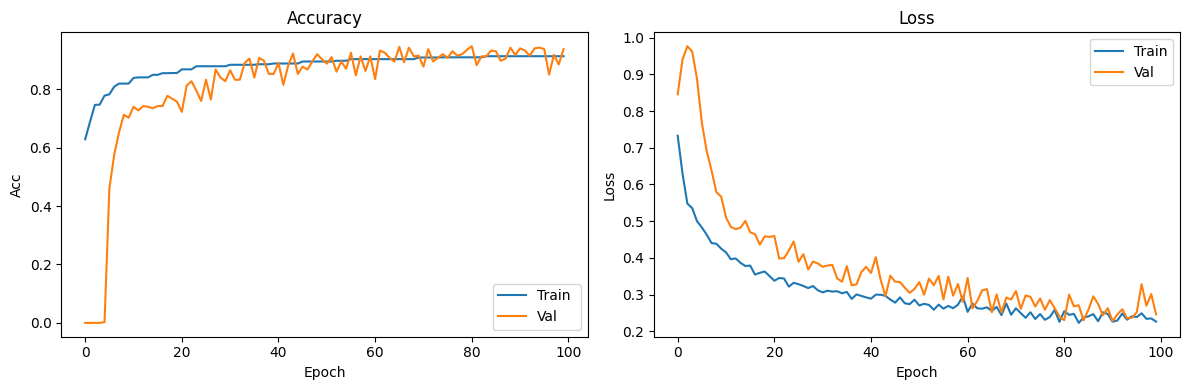

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Best F1 of 0.818 at threshold = 0.766
Confusion Matrix:
 [[214   6]
 [  2  18]]
Precision: 0.75
Recall:    0.9
F1-score:  0.8181818181818182
Overall accuracy: 0.9666666666666667
Accuracy on NORMAL class:  0.973 (214/220)
Accuracy on ANOMALY class: 0.900 (18/20)


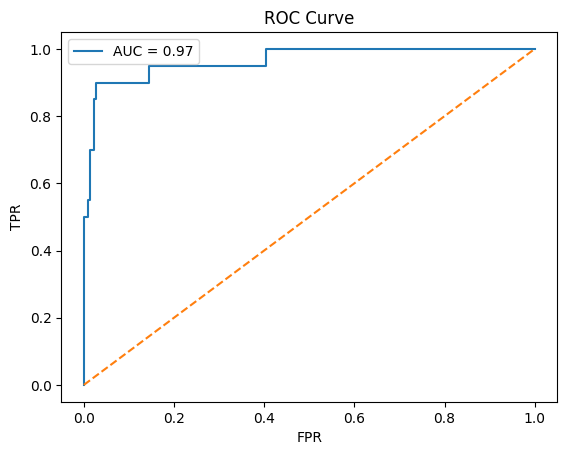

First 5 False Positives:
      loss_seq  loss_static  loss_psy  loss_role  true  pred group
6    0.192546    -0.042676  0.235511  -0.142870     0     1   0→1
75   1.297242     1.549733  0.027731   1.124732     0     1   0→1
95   0.449878     0.382954  0.287282   1.683377     0     1   0→1
105  1.025520    -0.193772  1.143857  -0.138039     0     1   0→1
110  0.180996     0.014040  0.207519  -0.251541     0     1   0→1 

First 5 False Negatives:
      loss_seq  loss_static  loss_psy  loss_role  true  pred group
78   0.348453    -0.046763 -0.128350   0.292452     1     0   1→0
222  0.020463    -0.425322  0.090182   0.646069     1     0   1→0 

Mean loss‐features by group:
                  loss_seq  loss_static  loss_psy  loss_role
group                                                      
True Negatives   4.065575    -0.128863  4.865770   0.429599
False Positives  0.493315     0.199250  0.295440   0.370458
False Negatives  0.184458    -0.236043 -0.019084   0.469261
True Positives   0.2

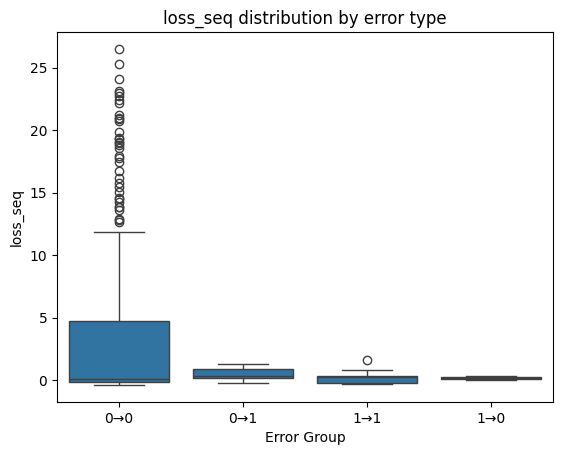

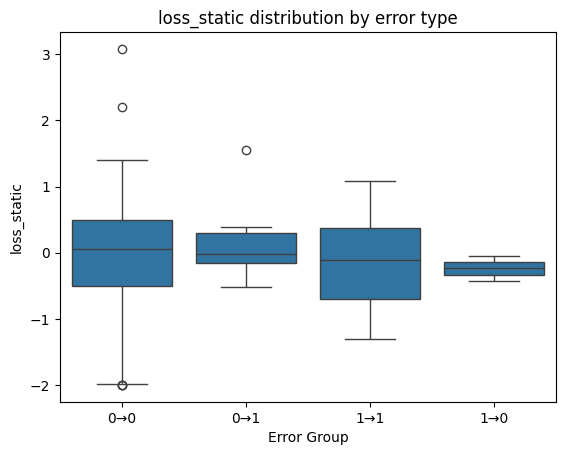

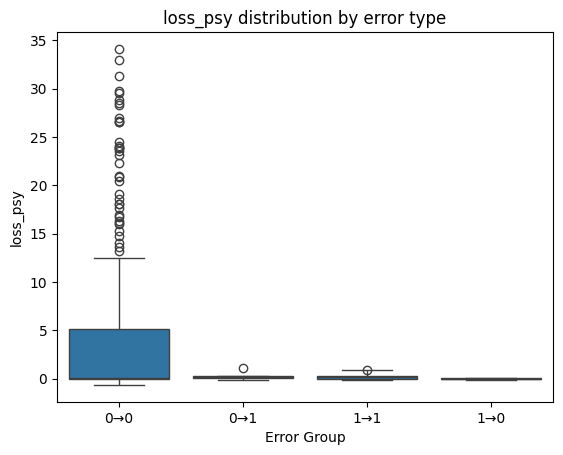

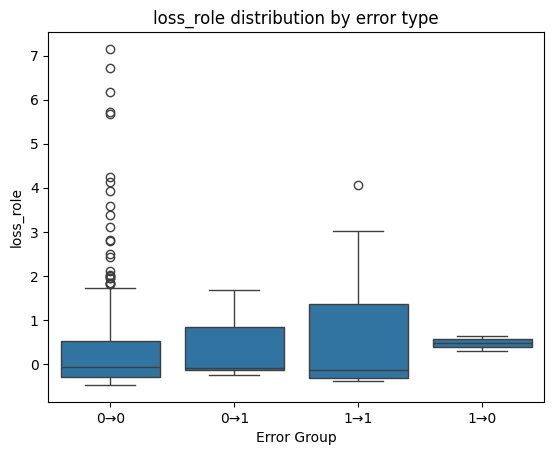

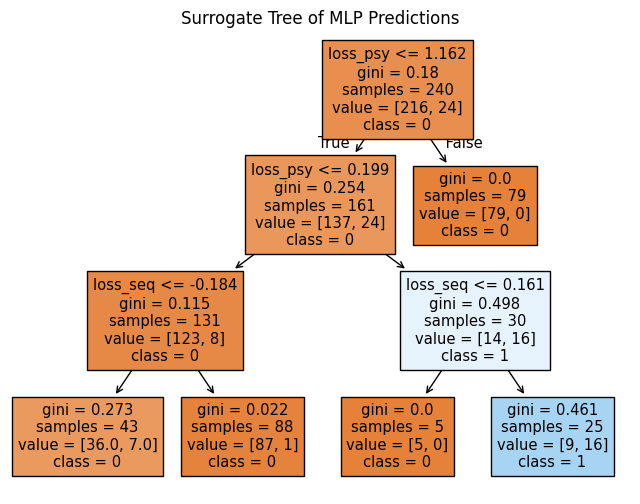

Normal_Number:  220  Abnormal_Number:  20
Matched 231 out of 240 samples
Overall accuracy: 0.9625


In [267]:

def train_test_val_generate(data_all, label_all,train_data_save, train_label_save,val_data_save,   val_label_save,test_data_save,  test_label_save,train_rate=0.7,  val_rate=0.15):   
    '''
Extract the "train_rate" percentage data for training, the "val_rate" percentage for validation, and the rest for testing.    '''

    with open(data_all,  'r') as f_data, \
         open(label_all, 'r') as f_label:
        data_lines  = f_data.readlines()
        label_lines = f_label.readlines()

    # zip, shuffle, unzip
    combined = list(zip(data_lines, label_lines))
    random.shuffle(combined)
    data_lines, label_lines = zip(*combined)


    # 1) figure out our sizes
    data_num  = count_line(data_all)
    train_num = int(data_num * train_rate)
    val_num   = int(data_num * val_rate)
    test_num  = data_num - train_num - val_num
    print(f"Shuffled split → Train: {train_num},  Val: {val_num},  Test: {test_num}")

    # 2) now open the output files
    data_train = open(train_data_save, 'wt')
    data_val   = open(val_data_save,   'wt')
    data_test  = open(test_data_save,  'wt')
    label_train= open(train_label_save,'wt')
    label_val  = open(val_label_save,  'wt')
    label_test = open(test_label_save, 'wt')

        # now write out the shuffled lines
    for i, line in enumerate(data_lines):
        if i < train_num:
            data_train.write(line)
        elif i < train_num + val_num:
            data_val.write(line)
        else:
            data_test.write(line)

    data_train.close()
    data_val.close()
    data_test.close()
    
    for i, lab in enumerate(label_lines):
        if i < train_num:
            label_train.write(lab)
        elif i < train_num + val_num:
            label_val.write(lab)
        else:
            label_test.write(lab)


    label_train.close()
    label_val.close()
    label_test.close()

def plot_metrics(precision, recall, f1score):
    labels = ['Précision', 'Rappel', 'F1-score']
    values = [precision, recall, f1score]
    plt.bar(labels, values, color=['blue', 'green', 'orange'])
    plt.ylabel('Scores')
    plt.title('Scores des Métriques')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train(files_train, labels_train, model_path,
          files_test, label_test, predict_save):
    

    # ─── 1) Load, winsorize & robust‐scale the training data ───────────────
    # a) load raw losses
    X_train = np.loadtxt(files_train, delimiter=',')
    y_train = np.loadtxt(labels_train, delimiter=',')

    # b) winsorize each column at its [1%, 99%] quantiles
    clip_bounds = [(X_train[:, j].min(), X_train[:, j].max())
                   for j in range(X_train.shape[1])]

    # c) robust‐scale (median & IQR)
    scaler = RobustScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # ─── 2) Oversample the minority class with SMOTE ────────────────────────
    if y_train.ndim > 1:
        y_labels = np.argmax(y_train, axis=1)
    else:
        y_labels = y_train

    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(X_train, y_labels)
    y_res = to_categorical(y_res, num_classes=2)

    # ─── 3) Build the MLP with L2 + dropout ───────────────────────────────
    inp = Input(shape=(x_res.shape[1],))
    x   = Dense(256, activation='relu')(inp)
    x   = BatchNormalization()(x)
    x   = Dropout(0.1)(x)
    x   = Dense(128, activation='relu')(x)
    x   = BatchNormalization()(x)
    x   = Dropout(0.1)(x)
    x   = Dense(32, activation='relu')(x)
    x   = BatchNormalization()(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

    # ─── 4) Callbacks: LR reduction + early stopping ───────────────────────
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # ─── 5) Train on the balanced data ────────────────────────────────────
    history = model.fit(x_res, y_res,validation_split=0.2,epochs=100,batch_size=32,shuffle=True,
        callbacks=[reduce_lr,early_stop],
        verbose=1)
    model.save(model_path)

    # ─── 6) Plot training history ─────────────────────────────────────────
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(np.maximum.accumulate(history.history['accuracy']),
             label='Train ')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ─── 7) Evaluate on hold-out test set ─────────────────────────────────
    X_test = np.loadtxt(files_test, delimiter=',')
    y_test = np.loadtxt(label_test, delimiter=',')

    # apply identical winsorizing
    for j, (lo, hi) in enumerate(clip_bounds):
        X_test[:, j] = np.clip(X_test[:, j], lo, hi)
    # then the same robust scaling
    X_test = scaler.transform(X_test)

    # prep true labels
    if y_test.ndim > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    # predict & threshold
    from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
    y_probs = model.predict(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores       = 2 * precision * recall / (precision + recall)
    best_idx        = np.nanargmax(f1_scores)
    best_threshold  = thresholds[best_idx]
    best_f1         = f1_scores[best_idx]
    print(f"Best F1 of {best_f1:.3f} at threshold = {best_threshold:.3f}")

        # ─── threshold & binarize MLP probs ───────────────────────
    np.savetxt(predict_save, y_probs.reshape(-1,1), delimiter=',')
    y_pred = (y_probs >= best_threshold).astype(int)

    # ─── psych override ──────────────────────────────────────
    # thresholds from your surrogate tree
    psych_cut = -0.5
    seq_cut   =  2.773
    role_cut  =  1.067

    # X_test columns: [loss_seq, loss_static, loss_psy, loss_role]
    psych_vals = X_test[:, 2]
    seq_vals   = X_test[:, 0]
    role_vals  = X_test[:, 3]

    # override any window where psych is very low but seq or role is high
    override = (psych_vals <= psych_cut) & (
               (seq_vals > seq_cut) &
               (role_vals > role_cut)
           )

    # final prediction = original MLP OR override rule
    final_pred = (y_pred | override).astype(int)

    cm = confusion_matrix(y_true, final_pred, labels=[0,1])
    print("Confusion Matrix:\n", cm)
    print("Precision:", precision_score(y_true, final_pred))
    print("Recall:   ", recall_score(y_true, final_pred))
    print("F1-score: ", f1_score(y_true, final_pred))
    print("Overall accuracy:", (final_pred == y_true).mean())

    # ── class‐wise accuracies ─────────────────────────────────────────
    tn, fp, fn, tp = cm.ravel()
    normal_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    anomal_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    print(f"Accuracy on NORMAL class:  {normal_acc:.3f} ({tn}/{tn+fp})")
    print(f"Accuracy on ANOMALY class: {anomal_acc:.3f} ({tp}/{tp+fn})")

    # ─── re-compute ROC coords for plotting ───────────────────
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    # ─── ROC curve (unchanged) ────────────────────────────────
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_probs):.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
    plt.legend(); plt.show()

    # ─── 8) Error‐analysis: DataFrame of misclassifications ────────────────
    fp_idx = np.where((y_true==0)&(y_pred==1))[0]
    fn_idx = np.where((y_true==1)&(y_pred==0))[0]

    cols = ['loss_seq','loss_static','loss_psy','loss_role']
    df = pd.DataFrame(X_test, columns=cols)
    df['true'] = y_true
    df['pred'] = y_pred
    df['group'] = df['true'].astype(str) + '→' + df['pred'].astype(str)

    print("First 5 False Positives:\n", df.iloc[fp_idx].head(), "\n")
    print("First 5 False Negatives:\n", df.iloc[fn_idx].head(), "\n")

    # ─── 9) Summary stats by error group ──────────────────────────────────
    stats = (
        df
        .groupby('group')[cols]
        .mean()
        .rename(index={
            '0→0':'True Negatives',
            '1→1':'True Positives',
            '0→1':'False Positives',
            '1→0':'False Negatives'
        }))
    print("Mean loss‐features by group:\n", stats, "\n")

    # Boxplots for each feature
    for feat in cols:
        plt.figure()
        sns.boxplot(x='group', y=feat, data=df)
        plt.title(f"{feat} distribution by error type")
        plt.xlabel('Error Group'); plt.show()

    # ─── 10) Surrogate decision‐tree to “read out” MLP logic ─────────────
    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(X_test, y_pred)
    plt.figure(figsize=(8,6))
    plot_tree(tree, feature_names=cols,
              class_names=['0','1'], filled=True)
    plt.title("Surrogate Tree of MLP Predictions"); plt.show()

    return history, model, best_threshold

def Calculatte(pred_file, label_file):
    """
    Count how many predictions match the true labels.
    Assumes each file is a CSV with one column: the predicted (or true) class.
    """
    correct = 0
    total   = 0

    with open(pred_file,  'r') as fpred, \
         open(label_file, 'r') as flabel:

        pred_reader  = csv.reader(fpred)
        label_reader = csv.reader(flabel)

        for pred_row, label_row in zip(pred_reader, label_reader):
            pred_cls = int(pred_row[0])
            # second column of the one-hot is the anomaly flag
            true_cls = int(label_row[1])
            if pred_cls == true_cls:
                correct += 1
            total += 1

    print(f"Matched {correct} out of {total} samples")
    return correct


def Count_nor_ano(label_file):
    Num_nor = 0
    Num_ano = 0
    with open(label_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            # second column is the anomaly flag
            cls = int(row[1])
            if cls == 0:
                Num_nor += 1
            else:
                Num_ano += 1
    print('Normal_Number: ', Num_nor, ' Abnormal_Number: ', Num_ano)
    return Num_ano + Num_nor


# ======== Main entrypoint: split then train ========
if __name__ == "__main__":
    # ----- 1) Shuffle & split all mixed data -----
    data_all    = os.path.join(base_path, 'Mix', 'Mix_all_loss.csv')
    label_all   = os.path.join(base_path, 'Mix', 'Mix_all_label.csv')
    data_train  = os.path.join(base_path, 'Mix', 'train.csv')
    label_train = os.path.join(base_path, 'Mix', 'label_train.csv')
    data_val    = os.path.join(base_path, 'Mix', 'val.csv')
    label_val   = os.path.join(base_path, 'Mix', 'label_val.csv')
    data_test   = os.path.join(base_path, 'Mix', 'test.csv')
    label_test  = os.path.join(base_path, 'Mix', 'label_test.csv')

    # create the shuffled train/val/test splits
    train_test_val_generate(
        data_all, label_all,
        data_train, label_train,
        data_val,   label_val,
        data_test,  label_test,
        train_rate=0.7, val_rate=0.15
    )

    # ----- 2) Train the MLP -----
    model_path    = os.path.join(base_path, 'Mix', 'MLP.h5')
    predict_save  = os.path.join(base_path, 'Mix', 'predict.csv')
    predict_label = os.path.join(base_path, 'Mix', 'predict_label.csv')

    history, model, best_threshold = train(
     data_train, label_train,
     model_path,
     data_test,  label_test,
     predict_save
 )

    # ----- 3) Post‐processing predictions -----
    predicts = np.loadtxt(predict_save, delimiter=',')
    pred = np.where(predicts > best_threshold, 1, 0)
    np.savetxt(predict_label, pred, delimiter=',', fmt='%d')

    all_label = Count_nor_ano(label_test)
    correct   = Calculatte(predict_label, label_test)
    print("Overall accuracy:", correct / all_label)